<a name="top" id="top"></a>


$$ Google \space KSA \space Reviews $$

$$ Comprehensive \space Analysis $$


------------------

# Table of Contents

00. [Introduction](#0)
    - [Objective Overview](#0-1)
    - [Dataset Description](#0-2)
01. [Preparation](#1)
    - [Required Installs](#1-1)
    - [Libraries Import](#1-2)
    - [Global Misc. Settings](#1-3)
02. [Data Preprocessing](#2)
    - [Data Loading](#2-1)
    - [Data Exploration](#2-2)
    - [Tags Handling](#2-3)
    - [Data Transformations](#2-4)
03. [NLP Text Analysis](#3)
    - [Sentiment Classification](#3-1)
    - [Theme Classification](#3-2)
04. [EDA & Visual Insights](#4)
05. [Conclusion](#5)
    - [Summary](#5-1)
    - [Recommendations](#5-2)

-----------------------

# `00.` Introduction <a name="0" id="0"></a>


## `i.` Objective Overview <a name="0-1" id="0-1"></a>

[Back to Top](#top)

1. Data Preprocessing and Transformation:
    - Extract structured information from JSON-encoded columns.
    - Generate new columns from the ratings.
    - Derive a sentiment column.

2. Text Cleaning and NLP Analysis:
    - Clean the review text.
    - Identify common keywords and themes.

3. Exploratory Data Analysis (EDA):
    - Analyze the distribution of sentiments, offerings, destinations, and ratings.
    - Investigate patterns or correlations between different variables.

## `ii.` Dataset Description <a name="0-2" id="0-2"></a>

[Back to Top](#top)

The provided dataset consist of two files:

1. Reviews Dataset File
> `dataset.csv_(DS_A-L2).csv`

| Column Name | Data Type | Description   |
|:-------------:|:-----------:|---------------------|
| id          | String   | Unique identifier for each review. |
| content     | String      | Text content of the review.   |
| date        | String      | Date when the review was posted (e.g., `2021-04-11T08:23:00+00:00`)    |
| language    | String      | Language of the review text          |
| tags        | String      | List of **hashed tags** associated with the review (category and city pairs) in _JSON_ document format |
| title       | String      | Title of the review |
| ratings     | String   | Rating given by the user in a _JSON_ document format having both **normalized** and **raw** rating values |

2. Tags Mapping File
> `mappings.json_(DS_A-L2).json`

This file contains the **hash mappings** for the `tag` column in the `dataset.csv_(DS_A-L2).csv` file. Document structure:
```python
{
    "tags_mapping":
        {
            "hash": ["Category", "City"], # Template
            "c07bbj4bb64t6si78rh0": ["Food & Beverage", "Abha"],
            .
            .
            .
            "c07bbvvepd3oq1r122o0": ["Retail", "Abha"]
        }
}
```

--------------------

# `01.` Preparation <a name="1" id="1"></a>

Steps in preparation of the workspace where the analysis aspects will be explored, discussed, and completed.

> _"By failing to prepare, you're preparing to fail."_
>
> **— Benjamin Franklin**

## `i.` Required Installs <a name="1-1" id="1-1"></a>

[Back to Top](#top)

In [2]:
%%capture
# deep-translator is used for text translation
!pip install -U deep-translator
# Huggingface transformers
!pip install -U transformers
# emoji is used for handling emojis
!pip install -U emoji

## `ii.` Library Imports <a name="1-2" id="1-2"></a>

[Back to Top](#top)

In [3]:
import re
import nltk
import json
import torch
import emoji
import string
import datetime
import numpy as np
import pandas as pd
from math import ceil
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from transformers import pipeline
from nltk.corpus import stopwords
from IPython.display import display
from typing import Tuple, List, Dict
from deep_translator import GoogleTranslator
from sklearn.preprocessing import OneHotEncoder
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset


## `iii.` Global Misc. Settings <a name="1-3" id="1-3"></a>

[Back to Top](#top)

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
root_dir = '/content/drive/My Drive/KSA_Reviews_Analysis'

In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
nltk.download('stopwords')
stop_words = set(stopwords.words('arabic'))\
                .union(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


------------------

# `02`. Data Preprocessing <a name="2" id="2"></a>

## `#` Helper Code

[Back to Top](#top)

In [8]:
class WorkspaceManager:
    def __init__(self, root_dir: str) -> None:
        """A class to manage the workspace.

        Args:
            root_dir (str): The root directory of the workspace.

        Attributes:
            root_dir_ (str): The root directory of the workspace.

        Methods:
            save_data(df: pd.DataFrame, filename: str, **kwargs: str) -> None:
                Save a DataFrame to a `csv` file.
            load_data(filename: str, **kwargs: str) -> pd.DataFrame:
                Load a DataFrame from a `csv` file.
        """
        self.__root_dir = root_dir

    def save_data(
            self, df: pd.DataFrame, filename: str, **kwargs: str
            ) -> None:
        """Save a DataFrame to a `csv` file. The file will be saved in a \
        `data` subdirectory. Default arguments include:
        - `index` = False
        - `sep` = '\\t'
        - `encoding` = 'utf-8'

        These arguments can be overriden through kwargs.

        Args:
            df (pd.DataFrame): The DataFrame to be saved.
            filename (str): The filename of the output `csv` file.
            **kwargs: Keyword arguments for `to_csv` function.
        """
        kwds = dict(index=False, sep='\t', encoding='utf-8')
        kwds.update(kwargs)
        df.to_csv(
                f'{self.__root_dir}/data/{filename}',
                **kwds
            )

    def load_data(
            self, filename: str, **kwargs: str
            ) -> pd.DataFrame:
        """Load a DataFrame from a `csv` file. The file will be loaded from a \
        `data` subdirectory. Default arguments include:
        - `sep` = '\\t'
        - `encoding` = 'utf-8'

        These arguments can be overriden through kwargs.

        Args:
            filename (str): The filename of the input `csv` file.
            **kwargs: Keyword arguments for `read_csv` function.

        Returns:
            pd.DataFrame: The DataFrame loaded from the `csv` file.

        """
        kwds = dict(sep='\t', encoding='utf-8')
        kwds.update(kwargs)
        df = pd.read_csv(
                f'{self.__root_dir}/data/{filename}',
                **kwds
            )
        return df

    @property
    def root_dir_(self) -> str:
        """Get the root directory of the workspace.

        Returns:
            str: The root directory of the workspace.
        """
        return self.__root_dir

In [9]:
wm = WorkspaceManager(root_dir)

## `i.` Data Loading <a name="2-1" id="2-1"></a>

[Back to Top](#top)

In [40]:
df = wm.load_data('dataset.csv_(DS_A-L2).csv', sep=',')

with open(f'{wm.root_dir_}/data/mappings.json_(DS_A-L2).json', 'r') as f:
    mappings = json.load(f)

## `ii.` Data Exploration <a name="2-2" id="2-2"></a>

[Back to Top](#top)

### `*` Data Preview

In [41]:
df.head()

,id,content,date,language,tags,title,ratings
0,377380-203583770957,من الاماكن الهاديه الجميله الممتعه في التسوق تحس انك بالخبر,2021-04-11T06:45:00+00:00,ara,"[{'value': 'c07bdfc8hb0r13sa7agg', 'sentiment': None}, {'value': 'c07bdfc8hb0r13sa7ah0', 'sentiment': None}]",Al Ahsa Mall by Arabian Centres,"{'normalized': 100, 'raw': 5}"
1,377380-203585579625,مساحة خضراء تتنفس فيها الهواء النقي .. المناظر الطبيعية ..الالعاب الترفيهية المناسبة للأطفال 😍😍 بحر الخليج,2021-04-11T06:45:00+00:00,ara,"[{'value': 'c07bdncbb64t6si78ssg', 'sentiment': None}, {'value': 'c07bdofepd3oq1r123kg', 'sentiment': None}, {'value': 'c0rquskbb64sdb6ukkq0', 'sentiment': None}, {'value': 'c0rqv8sbb64sdb6ukks0', 'sentiment': None}, {'value': 'c07bdifepd3oq1r122rg', 'sentiment': None}]","King Abdullah Park, Sea front","{'normalized': 100, 'raw': 5}"
2,377380-203590496913,nice place,2021-04-11T06:45:00+00:00,eng,"[{'value': 'c0rlhqgcu1i938rekca0', 'sentiment': None}]",Green Mountain Resort,"{'normalized': 100, 'raw': 5}"
3,377380-203589330972,جميل❤,2021-04-11T06:45:00+00:00,ara,"[{'value': 'c9ga0skbb64rs4ni6s7g', 'sentiment': None}]",Waterfront Beach Royal Commission Yanbu,"{'normalized': 80, 'raw': 4}"
4,377380-203586632060,جميييل,2021-04-11T06:45:00+00:00,ara,"[{'value': 'c07bdncbb64t6si78ssg', 'sentiment': None}, {'value': 'c07bdifepd3oq1r122rg', 'sentiment': None}]",Dammam Corniche,"{'normalized': 100, 'raw': 5}"


In [42]:
mappings

{'tags_mapping': {'c07bbh0cu1iccnqmcq00': ['Accommodation', 'Abha'],
  'c07bbj4bb64t6si78rh0': ['Food & Beverage', 'Abha'],
  'c07bbvvepd3oq1r122o0': ['Retail', 'Abha'],
  'c9g7nos8hb0qun2qahmg': ['Religious', 'Abha'],
  'c9g7o87epd3vh6lri8bg': ['Tourism Attractions/ Sites', 'Abha'],
  'c07bdfc8hb0r13sa7afg': ['Accommodation', 'Al Ahsa'],
  'c07bdfc8hb0r13sa7ag0': ['Food & Beverage', 'Al Ahsa'],
  'c07bdfc8hb0r13sa7agg': ['Tourism Attractions/ Sites', 'Al Ahsa'],
  'c07bdfc8hb0r13sa7ah0': ['Retail', 'Al Ahsa'],
  'c07bdfc8hb0r13sa7amg': ['Religious', 'Al Ahsa'],
  'c07bdg8cu1iccnqmcq70': ['Accommodation', 'Al Baha'],
  'c07bdg8cu1iccnqmcq7g': ['Food & Beverage', 'Al Baha'],
  'c07bdg8cu1iccnqmcq8g': ['Retail', 'Al Baha'],
  'c9g7u2k8hb0qun2qahn0': ['Religious', 'Al Baha'],
  'c9g7u348hb0qun2qahng': ['Tourism Attractions/ Sites', 'Al Baha'],
  'c07bdh4bb64t6si78rpg': ['Accommodation', 'Al Ula'],
  'c07bdh4bb64t6si78rq0': ['Food & Beverage', 'Al Ula'],
  'c9g8l0c8hb0qun2qahqg': ['Religio

### `*` Simple Analysis

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        10000 non-null  object
 1   content   10000 non-null  object
 2   date      10000 non-null  object
 3   language  10000 non-null  object
 4   tags      10000 non-null  object
 5   title     10000 non-null  object
 6   ratings   9990 non-null   object
dtypes: object(7)
memory usage: 547.0+ KB


In [55]:
print(f'Duplicate records: {df.duplicated().sum()}')

Duplicate records: 11


In [62]:
pd.DataFrame(
    df.language.value_counts(normalize=True, dropna=False)*100
             )

,proportion
language,
ara,76.1
eng,23.9


**Notes:**
- The data contains $10,000$ records.
- There are $10$ `null` values in the `ratings` column.
- $11$ data records are duplicates.
- Some columns have unusual data types:
    - `date` column should be of _datetime_ type.
    - `ratings` column should be of _numerical_ type.
- `tags` column requires few transformations before it can be used for insights.
- As per the `language` column, $76.1\%$ of the reviews are written in **Arabic**.

----------------------

## `iii.` Tags Handling <a name="2-3" id="2-3"></a>

[Back to Top](#top)

The `tags` is a string column that contains a list of _JSON_ documents. A single document is in the format:
```python
{"value": "hashed_value", "sentiment": None}
```

In order to be able to utilize and extract insights from this column, I have opted to use the following steps:
1. **Clean** and **convert** the tags string to a _list of dictionaries_.
2. **Expand** the tags column into $2 \times n$ columns:
    - Columns are in the format of category\_$i$, city\_$i$ representing the $i^{th}$ (category, city) pair extracted from the tags list.
    - Where $i \in [1, n+1)$ as an integer iterator.
    - And $n$ represents the $max$ length of a tags list overall the dataset (which was found to be $5$).
3. **Analyzing** and **collecting** unique _categories_ and _cities_.
4. **Generating** a _One-Hot Encoding_-like **representation** as an alternative (or an addition?) to the category\_$i$, city\_$i$ representation.


### `*` Helper Functions

In [63]:
def clean_tags_column(tags: str) -> List[Dict[str, List[str]]]:
    """Clean list of tags string and convert it to a list of dictionaries.
    The cleaning includes:
    - Replacing single quotes with double quotes.
    - Replacing `None` with `null`.

    Conversion happens through `json.loads` function.

    Args:
        tags (str): the string containing list of tag documents.

    Returns:
        List[Dict[str, List[str]]]: List of dictionaries in the format \
        `{"value":"hashed_value", "sentiment": None}`
    """
    tags = tags.replace("'", '"')
    tags = tags.replace("None", "null")
    tags = json.loads(tags)
    return tags

In [70]:
def expand_tags(
        row: pd.Series, mappings: Dict[str, List[str]], n: int=5
        ) -> List[str]:
    """Expand `clean_tags` column into `2 * n` columns in the format of \
    `category_i`, `city_i`.

    Args:
        row (pd.Series): DataFrame row values as a `pd.Series` format with \
        column names as index.
        mappings (Dict[str: List[str]]): Mapping dictionary. Each entry is in \
        the format of `"hashed_value": ["category", "city"]`
        n (int, optional): Max length of tags list overall the dataset. \
        Defaults to 5.

    Returns:
        List[str]: List of category, city values extracted from tags list.
    """
    t = []
    for r in row.clean_tags:
        t.extend(mappings.get(r['value']))
    # Pad with None values if tags list length is smaller than 2n
    if len(t) != (2*n):
        t.extend([None]*((2*n)-len(t)))
    return t

In [71]:
def expanded_tags_col_names(
        n: int, cat_prefix: str='category', city_prefix: str='city'
        ) -> List[str]:
    """Generate the column names for the expanded tags list.

    Args:
        n (int): Max length of the tags list overall the dataset.
        cat_prefix (str, optional): The prefix to use for category columns. \
        Defaults to 'category'.
        city_prefix (str, optional): The prefix to use for city columns. \
        Defaults to 'city'.

    Returns:
        List[str]: List of generated column names.
    """
    col_names = []
    for i in range(1, n+1):
        col_names.extend([f'{cat_prefix}_{i}', f'{city_prefix}_{i}'])
    return col_names

In [13]:
def analyze_unique_values(
        df: pd.DataFrame, col_prefix: str, n: int, verbose: bool=True
        ) -> List[str]:
    """Analyze and aggregate unique values in columns \
    with the format `col_prefix_i`.

    Postfix `i` should be in the range of (1, n) inclusive.

    Args:
        df (pd.DataFrame): The DataFrame to be analyed.
        col_prefix (str): The prefix of the columns to be analyzed.
        n (int): The number of columns with the prefix.
        verbose (bool, optional): Whether to print counts. Defaults to True.

    Returns:
        List[str]: List of unique values aggregated from all columns.
    """
    values = set()
    for i in range(1, n+1):
        s = set(df[f'{col_prefix}_{i}'].value_counts().index.tolist())
        if verbose:
            print(
                f'[{i}] Count of unique values in {col_prefix}_{i} '
                + f'column: {len(s)}'
                )
        values.update(s)
    values = list(values)
    if verbose:
        print(f'Total count of unique values: {len(values)}!')
    return values

In [73]:
def encode_category_city_values(
      df: pd.DataFrame, n: int, col_prefixes: List[str]=['category', 'city']
      ) -> pd.DataFrame:
    """Generate a One-Hot Encoding-like representation for the two categorical \
        groups of columns.

    Args:
        df (pd.DataFrame): The DataFrame containing the groups of columns.
        n (int): Number of columns with each prefix
        col_prefixes (List[str], optional): A list of column prefix per column \
            group. Defaults to ['category', 'city'].

    Returns:
        pd.DataFrame: DataFrame with the groups of columns encoded to reflect \
            the presence of each tag in the review.
    """
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')\
                        .fit(
                            df[
                                [f'{col_prefixes[0]}_1', f'{col_prefixes[1]}_1']
                              ].values
                            )
    tags_ohe = np.clip(
        np.array(
                  [
                      encoder.transform(
                      df[
                          [f'{col_prefixes[0]}_{i}', f'{col_prefixes[1]}_{i}']
                        ].values
                      ) for i in range(1, n+1)
                  ]
                ).sum(axis=0),
        None, 1)
    tags_df=pd.DataFrame(
        tags_ohe,
        columns=[
            c.replace('x0_', '').replace('x1_', '')
                for c in encoder.get_feature_names_out()
        ])
    return tags_df

### `*` Tags Cleaning & Expansion

In [231]:
# Max length of the tags list overall the dataset
n = df.tags.map(lambda x: len(eval(x))).max()

df['clean_tags'] = df['tags'].apply(clean_tags_column)

In [216]:
tags = df.apply(
    expand_tags, args=(mappings['tags_mapping'], n),
    axis=1, result_type='expand'
    )
tags.columns = expanded_tags_col_names(n)

In [77]:
tags.sample(5)

,category_1,city_1,category_2,city_2,category_3,city_3,category_4,city_4,category_5,city_5
7544,Accommodation,Riyadh,Tourism Attractions/ Sites,Riyadh,None,None,None,None,None,None
2896,Tourism Attractions/ Sites,Al Namas,None,None,None,None,None,None,None,None
8864,Food & Beverage,Jeddah,None,None,None,None,None,None,None,None
489,Tourism Attractions/ Sites,Madinah,Tourism Attractions/ Sites,Riyadh,None,None,None,None,None,None
2298,Tourism Attractions/ Sites,Madinah,None,None,None,None,None,None,None,None


### `*` Analyzign Unique Values

In [14]:
categories = analyze_unique_values(tags, 'category', 5)

[1] Count of unique values in category_1 column: 5
[2] Count of unique values in category_2 column: 5
[3] Count of unique values in category_3 column: 5
[4] Count of unique values in category_4 column: 2
[5] Count of unique values in category_5 column: 2
Total count of unique values: 5!


In [15]:
cities = analyze_unique_values(tags, 'city', 5)

[1] Count of unique values in city_1 column: 22
[2] Count of unique values in city_2 column: 18
[3] Count of unique values in city_3 column: 8
[4] Count of unique values in city_4 column: 2
[5] Count of unique values in city_5 column: 2
Total count of unique values: 22!


### `*` Encoding Representation

In [219]:
encoded_tags = encode_category_city_values(tags, n=5)

In [83]:
encoded_tags.sample(5)

,Accommodation,Food & Beverage,Religious,Retail,Tourism Attractions/ Sites,Abha,Al Ahsa,Al Baha,Al Diriyah,Al Namas,...,Madinah,Makkah,Qassim,Riyadh,Sakaka / AlJouf,Tabuk,Taif,Tanomah,Umluj,Yanbu
6962,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7118,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6926,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
826,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1743,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Notes:**
- We have added $1$ new column in this section:

Column|Description
:--------:|------------
`clean_tags`|**Cleaned** and **converted** tags.

- We have also extracted the _categories_ and _cities_ in two formats:
    - `tags` DataFrame which have $10$ columns from (`category_1`, `city_1`) to (`category_5`, `city_5`) with each pair of columns representing each tag in the tags list.
    - `encoded_tags` DataFrame which have $27$ columns representing the **combined** unique values of _categories_ and _cities_ ($5$ unique _categories_ and $22$ unique _cities_)
- Each of these DataFrames contain $10,000$ records (as in the original DataFrame).
- Thus, they could be used to extract insights.

----------------------

## `iv.` Data Transformations <a name="2-4" id="2-4"></a>

[Back to Top](#top)

Applying the necessary transformations on the data in preparation for next phases (e.g., _Text Analysis_, _Insight Extraction_, etc.).

The transformations include:
- Translating review text to English using `deep_translator` library. This is due to the following factors:
    - Arabic text _especially_ non-MSA  (i.e., dialect Arabic) usually introduce several challenges for analysis; since:
        - It contains words that are **mistyped**, **exaggerated**, **non-Arabic**, etc.
        - Some people could write Arabic words the way they speak them (disregarding whether that's the correct standard way).
        - Even within a single counrtry (e.g., _Saudi Arabia_), dialectal variations occur.
    - Analyzing text in a multi-lingual dataset would be more complex than a mono-lingual one.
    - There are some reviews that are neither English nor Arabic.
- Cleaning review text to reach a more pure and normalized version that could ease analysis. Preprocessing steps used include:
    - Remove duplicate text due to Google Translating the original review.
    - Remove Punctuations.
    - Remove duplicate emojis.
    - Replace emojis with their meaning.
    - Remove extra whitespaces.
    - Remove stop-words.
- Converting `date` column to datetime object instead of string.
    - It's a straight forward process since the dates have the same format with no _null_ values.
    - We will also remove _timezone_ information since it's redundant.
- Extracting ratings from `ratings` column:
    - This column is a string in the format of _JSON_ document (e.g., `{"normalized": 100, "raw": 5}`).
    - There are some _null_ values that require handling.
    - I opted to extract the _normalized_ rating rather than the raw one; since **rating scales** are different (e.g., out of 5, 10, etc.)


### `*` Helper Functions

In [84]:
def remove_extra_whitespaces(text: str) -> str:
    """Remove extra whitespaes from input text.

    Args:
        text (str): Input text.

    Returns:
        str: Output text with no extra whitespaces.
    """
    text = re.sub(r'\s+', ' ', text)
    return text

In [85]:
def translate_text_to_en(text: str, translator: GoogleTranslator) -> str:
    """Translate review text from any source language to English \
        for a normalized data pipeline.

        Additionally, the fuction handles maximum characters per \
        request (5000) enforced by the translation API.


    Args:
        text (str): Input text to be translated.
        translator (GoogleTranslator): GoogleTranslator instance from \
            `deep_translator` to be used to translate text.

    Returns:
        str: Translated English text.
    """
    try:
        # Handle maximum characters per request
        if len(text) < 5000:
            translation = translator.translate(text)
        else:
            # Split by Original and Translated parts if exist
            if len(text) < 10_000 and 'More(Translated by Google)' in text:
                text_parts = [
                    translator.translate(part)
                      for part in text.split('(Original)')
                    ]
                text_parts.insert(1, '(Original)')
            # Split normally using sentences if periods exist in text or words
            else:
                splitter = '.' if '.' in text else ' '
                splits = ceil(len(text)/5000)
                text_tokens = text.split(splitter)
                multiplier = len(text_tokens)//splits
                parts = [
                    splitter.join(
                        text_tokens[i*(multiplier):(i+1)*(multiplier)]
                        ) for i in range(splits)
                    ]
                text_parts = [translator.translate(part) for part in parts]
            translation = ' '.join(text_parts)
        return translation
    except Exception as e:
        print(f'Error: {e}')
        return text

In [86]:
def remove_duplicate_emojis(text: str) -> str:
    """Remove any duplicate emoji characters either directly adjacent or \
    separated by whitespaces.

    Args:
        text (str): Input text to be processed for duplicate emojis.

    Returns:
        str: Text free of duplicate emojis.
    """
    em_list = emoji.emoji_list(text)[::-1]
    # If there seems to be a duplicate emoji case
    if len(em_list) > len(emoji.distinct_emoji_list(text)):
        # Loop over the emoji matches
        for i in range(len(em_list)):
            if i+1 < len(em_list):
                if (
                    ( # Emojis directly adjacent
                      (em_list[i]['match_start'] == em_list[i+1]['match_end'])
                      or
                      # Emojis separated with only whitespace(s)
                      (re.fullmatch(
                          r'\s+',
                          text[
                              em_list[i+1]['match_end']
                              :em_list[i]['match_start']
                              ]
                          )
                      )
                    )
                    and
                    # Emojis are identical
                    (em_list[i]['emoji']==em_list[i+1]['emoji'])
                    ):
                    # Slice out the duplicate emoji
                    text = text[:em_list[i]['match_start']] \
                            + text[em_list[i]['match_end']:]
    return text

In [95]:
def preprocess_text(text: str) -> str:
    """Preprocessing transformations for text that includes:
        - Remove duplicate text due to Google Translating the original review.
        - Remove Punctuations
        - Remove duplicate emojis
        - Replace emojis with their meaning
        - Remove extra whitespaces
        - Remove stop-words

    Args:
        text (str): Input text to be processed and cleaned.

    Returns:
        str: Preprocessed text.
    """
    # Remove Original section (duplicated content in case the
    # review was translated by Google)
    if 'More(Translated by Google)' in text:
        text = text.split('(Original)')[0]\
                  .replace('More(Translated by Google)', '')

    # Remove Punctuations
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove duplicate emojis
    text = remove_duplicate_emojis(text)

    # Replace emojis with their meaning
    text = emoji.demojize(text).replace('_', ' ').replace(':', ' ')

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stop words
    words = [word for word in text.split() if word not in stop_words]

    return ' '.join(words)

### `*` Review Text Arabic-to-English Translation

In [ ]:
df['raw_text'] = df['content'].apply(remove_extra_whitespaces)

In [ ]:
translator = GoogleTranslator(source='auto', target='en')

In [ ]:
df['translated_text'] = df.apply(lambda x: translate_text_to_en(x['raw_text'], translator) if re.match(r".*[ء-ي]", x['raw_text']) else x['raw_text'], axis=1)

### `*` Review Text Cleaning

In [ ]:
df['cleaned_text'] = df['translated_text'].apply(preprocess_text)

### `*` Date Conversion


In [229]:
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)

### `*` Ratings Extraction

In [230]:
df['ratings_num'] = df['ratings']\
                        .fillna('{"normalized": None}')\
                        .map(lambda x: eval(x)['normalized'])

### `*` Data Preview and Backup

In [91]:
df.sample(5)

,id,content,date,language,tags,title,ratings,raw_text,translated_text,cleaned_text,ratings_num
5113,377380-195172347039,كم سعر الفندق كامل؟ نفسي اشتريه .,2022-01-13 06:26:00+00:00,ara,"[{'value': 'c07bdkkbb64t6si78s20', 'sentiment': None}]",Jeddah Hilton Hotel,"{'normalized': 100, 'raw': 5}",كم سعر الفندق كامل؟ نفسي اشتريه .,How much is the full hotel price? I want to buy it.,How much full hotel price I want buy,100.0
9597,377380-167965932100,More(Translated by Google) Mecca longs for her heart and soul Psychological comfort in this place (Original) مكة تشتاق لها القلب والروح الراحة النفسية في هذا المكان,2021-02-14 00:00:00+00:00,ara,"[{'value': 'c07bja4bb64t6si78uvg', 'sentiment': None}]",Kaaba,"{'normalized': 100, 'raw': 5}",More(Translated by Google) Mecca longs for her heart and soul Psychological comfort in this place (Original) مكة تشتاق لها القلب والروح الراحة النفسية في هذا المكان,More(Translated by Google) Mecca longs for her heart and soul Psychological comfort in this place (Original),Mecca longs heart soul Psychological comfort place,100.0
142,377380-203583764879,Not found good stuff,2021-04-11 06:49:00+00:00,eng,"[{'value': 'c07bdfc8hb0r13sa7agg', 'sentiment': None}, {'value': 'c07bdfc8hb0r13sa7ah0', 'sentiment': None}]",Al Ahsa Mall by Arabian Centres,"{'normalized': 40, 'raw': 2}",Not found good stuff,Not found good stuff,Not found good stuff,40.0
3913,377380-203586064940,Very nice park,2021-04-11 08:17:00+00:00,eng,"[{'value': 'c07bdofepd3oq1r123kg', 'sentiment': None}]",Khararah Lake,"{'normalized': 100, 'raw': 5}",Very nice park,Very nice park,Very nice park,100.0
3102,377380-203583140757,جبال السودة عكس واقعها فهي الجبال الخضراء طوال العام,2021-04-11 07:59:00+00:00,ara,"[{'value': 'c9g7o87epd3vh6lri8bg', 'sentiment': None}]",Jabal Sawda,"{'normalized': 100, 'raw': 5}",جبال السودة عكس واقعها فهي الجبال الخضراء طوال العام,"The Souda Mountains are the opposite of their reality, they are green mountains all year round",The Souda Mountains opposite reality green mountains year round,100.0


In [88]:
wm.save_data(df, 'dataset_translated.csv')
df = wm.load_data('dataset_translated.csv')

**Notes:**
- We have added $4$ new columns in this section:

Column|Description
:--------:|------------
`raw_text`|**Original** text with extra whitespaces removed.
`translated_text`|**Raw** English _translated_ text.
`cleaned_text`|English translated text with **preprocessing**.
`ratings_num`|Extracted **normalized rating** (out of 100).

- We have also converted `date` column from _string_ to _datetime_ type and removed the timezone information.

-----------------------------

# `03.` NLP Text Analysis <a name="3" id="3"></a>

Analyzing review text in order to derive attributes such as:
- Text Sentiment [Positive, Neutral, Negative]
- Review Theme/Topic [e.g., Service, Location, etc.]

`Note:` Since this section relies mainly on `transformers`, I opted to use raw text (i.e., translated text wthout **preprocessing**). The reason is that _transformers_ are designed to handle **natural** text (i.e., with stop-words, punctuations, etc.)

## `#` Helper Code

[Back to Top](#top)

In [96]:
# Use Cuda if available
device = torch.device('cuda') if torch.cuda.is_available() \
                                  else torch.device('cpu')

# List of Models/Tasks to Try
models = [
    {'task': 'sentiment-analysis',
        'path': 'cardiffnlp/twitter-roberta-base-sentiment-latest'},
    {'task': 'sentiment-analysis',
        'path': 'lxyuan/distilbert-base-multilingual-cased-sentiments-student'},
    {'task': 'zero-shot-classification',
        'path': 'MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'},
    {'task': 'zero-shot-classification',
        'path': 'facebook/bart-large-mnli'}
    ]

print(f'Currently using: {device}!')

Currently using: cpu!


In [97]:
def analyze_sentiment(
    text: str, model_id: int, pipeline: pipeline
    ) -> Tuple[str, float]:
    """Derive the sentiment from the input text.

    Args:
        text (str): Input text to be analyzed.
        model_id (int): Id of the pre-trained model to be use for the analysis.
        pipeline (pipeline): The `transformers` pipeline to be \
        used for analysis.

    Returns:
        Tuple[str, float]: Predicted sentiment label and score for input text.
    """
    try:
        if models[model_id]['task'] in [
            'text_classification', 'sentiment-analysis'
            ]:
            output = pipeline(
                  text, truncation=True, max_length=512
                )[0]
            return output['label'], output['score']
        elif models[model_id]['task'] == 'zero-shot-classification':
            candidate_labels = ["Positive", "Neutral", "Negative"]
            output = pipeline(
                  text, candidate_labels, multi_label=False
                )
            return output['labels'][0], output['scores'][0]
    except Exception as e:
        print(f'Error: {e}\n\tText: {text}')
        return None, None

In [98]:
def analyze_theme(
    text: str, model_id: int, pipeline: pipeline,
    multi_label: bool = False, threshold: float = 0.75
    ) -> Tuple[str, float]:
    """Derive the theme from the input text with the capability to perform \
    multi-label classification.

    Args:
        text (str): Input text to be analyzed.
        model_id (int): Id of the pre-trained model to be use for the analysis.
        pipeline (pipeline): `transformers` pipeline to be used for analysis.
        multi_label (bool, optional): Whether to use multi-label \
        classification. Defaults to False.
        threshold (float, optional): Threshold for multi-label classification. \
        Defaults to 0.75.

    Returns:
        Tuple[str, float]: Predicted theme label and score for input text.
    """
    try:
        if models[model_id]['task'] == 'zero-shot-classification':
            candidate_labels = [
                "Service", "Product", "Price", "Experience",
                "Delivery", "Location", "Cleanliness"
            ]
            output = pipeline(text, candidate_labels, multi_label=multi_label)
            if multi_label:
                cut_idx = np.where(np.array(output['scores']) < threshold)[0]
                cut_idx = cut_idx[0] if len(cut_idx) > 0 \
                                        else len(output['scores'])
                cut_idx = 1 if cut_idx == 0 else cut_idx
                return output['labels'][:cut_idx], output['scores'][:cut_idx]
            else:
                return output['labels'][0], output['scores'][0]
    except Exception as e:
        print(f'Error: {e}\n\tText: {text}')
        return None, None

In [99]:
def show_distribution(
    df: pd.DataFrame,
    column: str,
    transpose: bool=True
    ) -> None:
    """Print out the distribution of unique values in a the `column` column
    in `df` DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame where the column resides.
        column (str): The column name in the DataFrame to be analyzed.
        transpose (bool, optional): Whether to present unique values as \
        columns (`True`) or as indices (`False`). Defaults to True.
    """
    col_distribution = df[column].value_counts()
    dist_df = pd.DataFrame(
                {'Count': col_distribution.values,
                'Percentage (%)': col_distribution.values/df.shape[0]*100},
                index=col_distribution.index)
    dist_df = dist_df.T if transpose else dist_df
    display(dist_df)

----------------

## `i.` Sentiment Classification <a name="3-1" id="3-1"></a>

[Back to Top](#top)

Since the `sentiment` attribute is missing (i.e., no _targets_), we cannot train a model from scratch (**except** through labelling some reviews myself which is not _feasible_ in the analysis tight duration).

Other approaches include:
- Using lexicon and rule-based algorithms like _VADER_:
  - However, it might not be accurate -especially- with sarcasm or irony.
  - Lexicon based algorithms might not be able to interpret negation very well.
- Using pre-trained classification models (mainly _transformers_):
  - However, those pre-trained models are usually **domain-specific** (i.e., they perform well on data similar to the distribution of their training data).
  - That's said, such models can produce acceptable predictions in cases like ours if the model is powerful enough.
- Utilizing pre-trained _NLI_ models for _Zero-shot Classification_:
  - This approach allows for classifying into **unseen** classes (which means they can be used for sentiment analysis).
  - The downside is that, this approach is usually **slower** than regular classifiers which won't be a challenge in this case since we are processing _batch data_.

In [101]:
%%capture

model_id = 2
sentiment_analysis_pipeline = pipeline(
    models[model_id]['task'],
    model=models[model_id]['path'],
    tokenizer=models[model_id]['path'],
    device=device
)

In [ ]:
df[['sentiment', 'sentiment_score']] = df['translated_text'].apply(lambda x: pd.Series(analyze_sentiment(x, model_id, sentiment_analysis_pipeline)))

---------------

### `*` Data Preview

In [ ]:
show_distribution(df=df, column='sentiment')

sentiment,Positive,Negative,Neutral
Count,8089.00,1580.0,331.00
Percentage (%),80.89,15.8,3.31


In [ ]:
df[['raw_text', 'translated_text', 'sentiment', 'sentiment_score']].sample(10)

,raw_text,translated_text,sentiment,sentiment_score
1785,جيد لكن لا تستهويني هالاماكن,"Good, but I don't like these places",Positive,0.878792
5670,رائع,amazing,Positive,0.988660
7002,"More(Translated by Google) Jabal Al-Qarah, als...","More(Translated by Google) Jabal Al-Qarah, als...",Neutral,0.500183
6656,خير بقاع الدنيا,The best parts of the world,Positive,0.985358
8879,من افضل المنتجات المطله ع البحر في جده من جميع...,One of the best products overlooking the sea i...,Positive,0.928293
9604,ما جيته,I didn't come,Negative,0.512839
663,لمكان غير مرتب,An untidy place,Negative,0.851191
8290,الفندق نظيف والخدمة جيده ويكفي قربه للحرم,"The hotel is clean, the service is good, and i...",Positive,0.891116
2119,قمة الروعة والجمال,The pinnacle of splendor and beauty,Positive,0.968767
7044,صغير، قاعات الاجتماعات الخدمة فيها سيئة.,"Small, meeting rooms with poor service.",Negative,0.958134


**Notes:**
- Since there are no ground truth values to compare model predictions against, I resorted to visual inspection for a few samples.
- That said, the predicted sentiment labels of the `zero-shot Classifier` seem more reliable than other approaches.


-----------------------

## `ii.` Theme Classification <a name="3-2" id="3-2"></a>

[Back to Top](#top)

Having no true labels (_targets_) at all for the reviews' themes, training a model from scratch is impossible (**except** through labelling some reviews myself which -again- is not _feasible_ in the analysis tight duration).

Other approaches include:
- Using algorithms like _Latent Dirichlet Allocation (LDA)_:
  - However since a review text is usually short and sometimes irrelevant.
  - Thus, we can consider the data _noisy_, _sparse_, and _heterogeneous_.
  - Under such conditions, LDA can produce ambiguous or incoherent topics.
- Using pre-trained classification models (mainly _transformers_):
  - However, those pre-trained models are usually **very specific** (i.e., topic/theme classes are tailored for the use case for which they were trained).
  - This might not be perfectly applicable or aligned with our use case.
- Utilizing pre-trained _NLI_ models for _Zero-shot Classification_:
  - This approach allows for classifying into **unseen** classes (i.e., we can come up with our own _candidate classes_ that are suitable for our requirements).
  - It's even possible to produce multi-label predictions using this appraoch.
  - The downside is that, this approach is usually **slower** than regular classifiers which won't be a challenge in this case since we are processing _batch data_.

In [128]:
%%capture

model_id = 3
theme_analysis_pipeline = pipeline(
    models[model_id]['task'],
    model=models[model_id]['path'],
    tokenizer=models[model_id]['path'],
    device=device
)

In [ ]:
# Multi-class Zero-shot Classification
df[['theme', 'theme_score']] = df['translated_text']\
      .apply(
          lambda x: pd.Series(
              analyze_theme(
                  x, model_id, theme_analysis_pipeline, multi_label=False
                  )
              )
          )

In [21]:
# Multi-label Zero-shot Classification
df[['themes', 'theme_scores']] = df['translated_text']\
      .apply(
          lambda x: pd.Series(
              analyze_theme(
                  x, model_id, theme_analysis_pipeline, multi_label=True
                  )
              )
          )
df['major_theme'] = df['themes'].apply(lambda x: x[0])

-------------------

### `*` Data Preview and Backup

In [44]:
show_distribution(df=df, column='theme')

theme,Location,Experience,Service,Cleanliness,Product,Price,Delivery
Count,3306.00,2318.00,1466.00,1248.00,1046.00,597.00,19.00
Percentage (%),33.06,23.18,14.66,12.48,10.46,5.97,0.19


In [25]:
show_distribution(df=df, column='major_theme')

major_theme,Location,Service,Experience,Cleanliness,Product,Price,Delivery
Count,3607.00,2136.00,1130.0,1093.00,987.00,935.00,112.00
Percentage (%),36.07,21.36,11.3,10.93,9.87,9.35,1.12


In [43]:
df[
    ['raw_text', 'translated_text', 'sentiment',
     'major_theme', 'themes', 'theme']
    ].sample(10)

,raw_text,translated_text,sentiment,major_theme,themes,theme
1800,منتزه يفتقر الى الخدمات الاساسية.. ولكن يعد مكان طبيعي جميل لالتقاط بعض الصور التذكارية وافضل الاوقات لزيارته في الصباح الباكر عند شروق الشمس,A park that lacks basic services.. but it is a beautiful natural place to take some souvenir photos and the best time to visit it is early in the morning at sunrise.,Positive,Location,[Location],Location
6334,جميل جدا ذو طابع تراثي,Very beautiful and has a traditional feel,Positive,Product,[Product],Experience
3941,جلسات جميله اطلاله مرتفعه,Beautiful seating with a high view,Positive,Location,[Location],Location
828,مكان عظيم يستحق الزيارة,Great place worth a visit,Positive,Experience,"[Experience, Location]",Location
470,عريق 👑,Ancient 👑,Positive,Experience,[Experience],Experience
9689,جميل جداً و هادي و بعيد عن الإزعاج و فخم و سعره معقول,"Very beautiful, quiet, far from noise, luxurious, and reasonably priced",Positive,Experience,"[Experience, Price, Location, Product, Service, Cleanliness]",Price
2108,Tabuk fort ancient building looks awesome .,Tabuk fort ancient building looks awesome .,Positive,Location,[Location],Location
3107,يكفيك النظافه,Cleanliness is enough for you,Positive,Cleanliness,[Cleanliness],Cleanliness
4342,اشهر مسجد في مدينة الرياض ويقع في وسط المدينة,The most famous mosque in Riyadh and located in the city center,Positive,Location,[Location],Location
9630,ممتازة استمتعت بوقتي فيها,"Excellent, I enjoyed my time there",Positive,Service,"[Service, Experience, Location]",Experience


In [236]:
wm.save_data(df, 'dataset_translated_with_sentiment_multi_themes.csv')
df = wm.load_data('dataset_translated_with_sentiment_multi_themes.csv')

------------------

### `*` Multi-class vs. Multi-label Classification

In [134]:
print(f"""Count of theme mismatches between multi-class and multi-label: {df[
    (df.theme_scores.apply(lambda x: eval(x)[0])<0.6)
    &(df.major_theme!=df.theme)
    ].shape[0]} records.""")

Count of theme mismatches between multi-class and multi-label: 1030 records.


In [136]:
df[
    (df.theme_scores.apply(lambda x: eval(x)[0])<0.6)
    &(df.major_theme!=df.theme)
    ][
        ['translated_text', 'major_theme', 'theme',
         'theme_scores', 'theme_score']
        ].sample(10)

,translated_text,major_theme,theme,theme_scores,theme_score
5703,It lacks attention and cleanliness,Price,Cleanliness,[0.29271015524864197],0.476932
9321,"Oh God, do not let this be our last promise.",Service,Product,[0.33547571301460266],0.201481
9047,More(Translated by Google) Dealing with clients is the worst possible There is no express service (Original),Price,Service,[0.22451874613761902],0.402555
8003,The only problem is crowding,Delivery,Price,[0.09182853996753693],0.208621
3295,Beautiful and quiet garden,Price,Cleanliness,[0.46415549516677856],0.253582
4267,Refreshing atmosphere9👍💗,Delivery,Experience,[0.41470906138420105],0.373844
2749,"If it were not for the existence of mosques, there would have been a major crisis regarding bathrooms. I do not know when the secretariat will give sufficient attention to bathrooms in public and tourist places and parks....!!!!",Service,Experience,[0.3833547532558441],0.262689
2427,Mind your soul,Delivery,Experience,[0.23880848288536072],0.261878
1909,"Beautiful, but cold, and there is a socket on the door. I wish I could change it. Even prayer says it is forbidden during times outside of prayer. Ok, if someone is traveling, what can he do if he stops praying? May God reach him. His behavior is zero dealings.",Location,Experience,[0.21614834666252136],0.278941
1608,amazing,Product,Experience,[0.5830767750740051],0.252176


**Notes:**
- There seems to be a mismatch between the `theme` (derived using _multi-class_ classification) and `major_theme` (derived using _multi-label_ classification).
- After inspecting a few random samples by eye, it can be assumed  that:
  - _Multi-label_ predictions deviate drastically from accuracy when top score is below $60\%$.
  - Meanwhile, the _multi-class_ output seems more reasonable for those records.
- I suggest using `major_theme` for scores above $60\%$ and falling back to `theme` below that threshold.

--------------------

# `04.` EDA & Visual Insights <a name="4" id="4"></a>


## `#` Final Touches & Data Backup

[Back to Top](#top)

Before starting to extract insights, we need to:
- Combine `major_theme` and `theme` together with a $60\%$ threshold as previously dicussed.
- drop the duplicate records from the $3$ DataFrames (i.e., `df`, `tags`, and `encoded_tags`).

In [268]:
df['combined_theme'] = df.apply(
    lambda x: x['theme']
                if eval(x['theme_scores'])[0]<0.6
                else x['major_theme'], axis=1
    )

In [237]:
idx_to_drop = df[df.duplicated(subset=['id'], keep='last')].index
df.drop(idx_to_drop, inplace=True)
tags.drop(idx_to_drop, inplace=True)
encoded_tags.drop(idx_to_drop, inplace=True)

In [ ]:
wm.save_data(df, 'dataset_processed.csv', index=True)
wm.save_data(tags, 'tags.csv', index=True)
wm.save_data(encoded_tags, 'encoded_tags.csv', index=True)

In [10]:
df = wm.load_data('dataset_processed.csv', index_col=0, parse_dates=['date'])
tags = wm.load_data('tags.csv', index_col=0)
encoded_tags = wm.load_data('encoded_tags.csv', index_col=0)

-----------------------------

## `#` Reviews by Category Over Time

[Back to Top](#top)

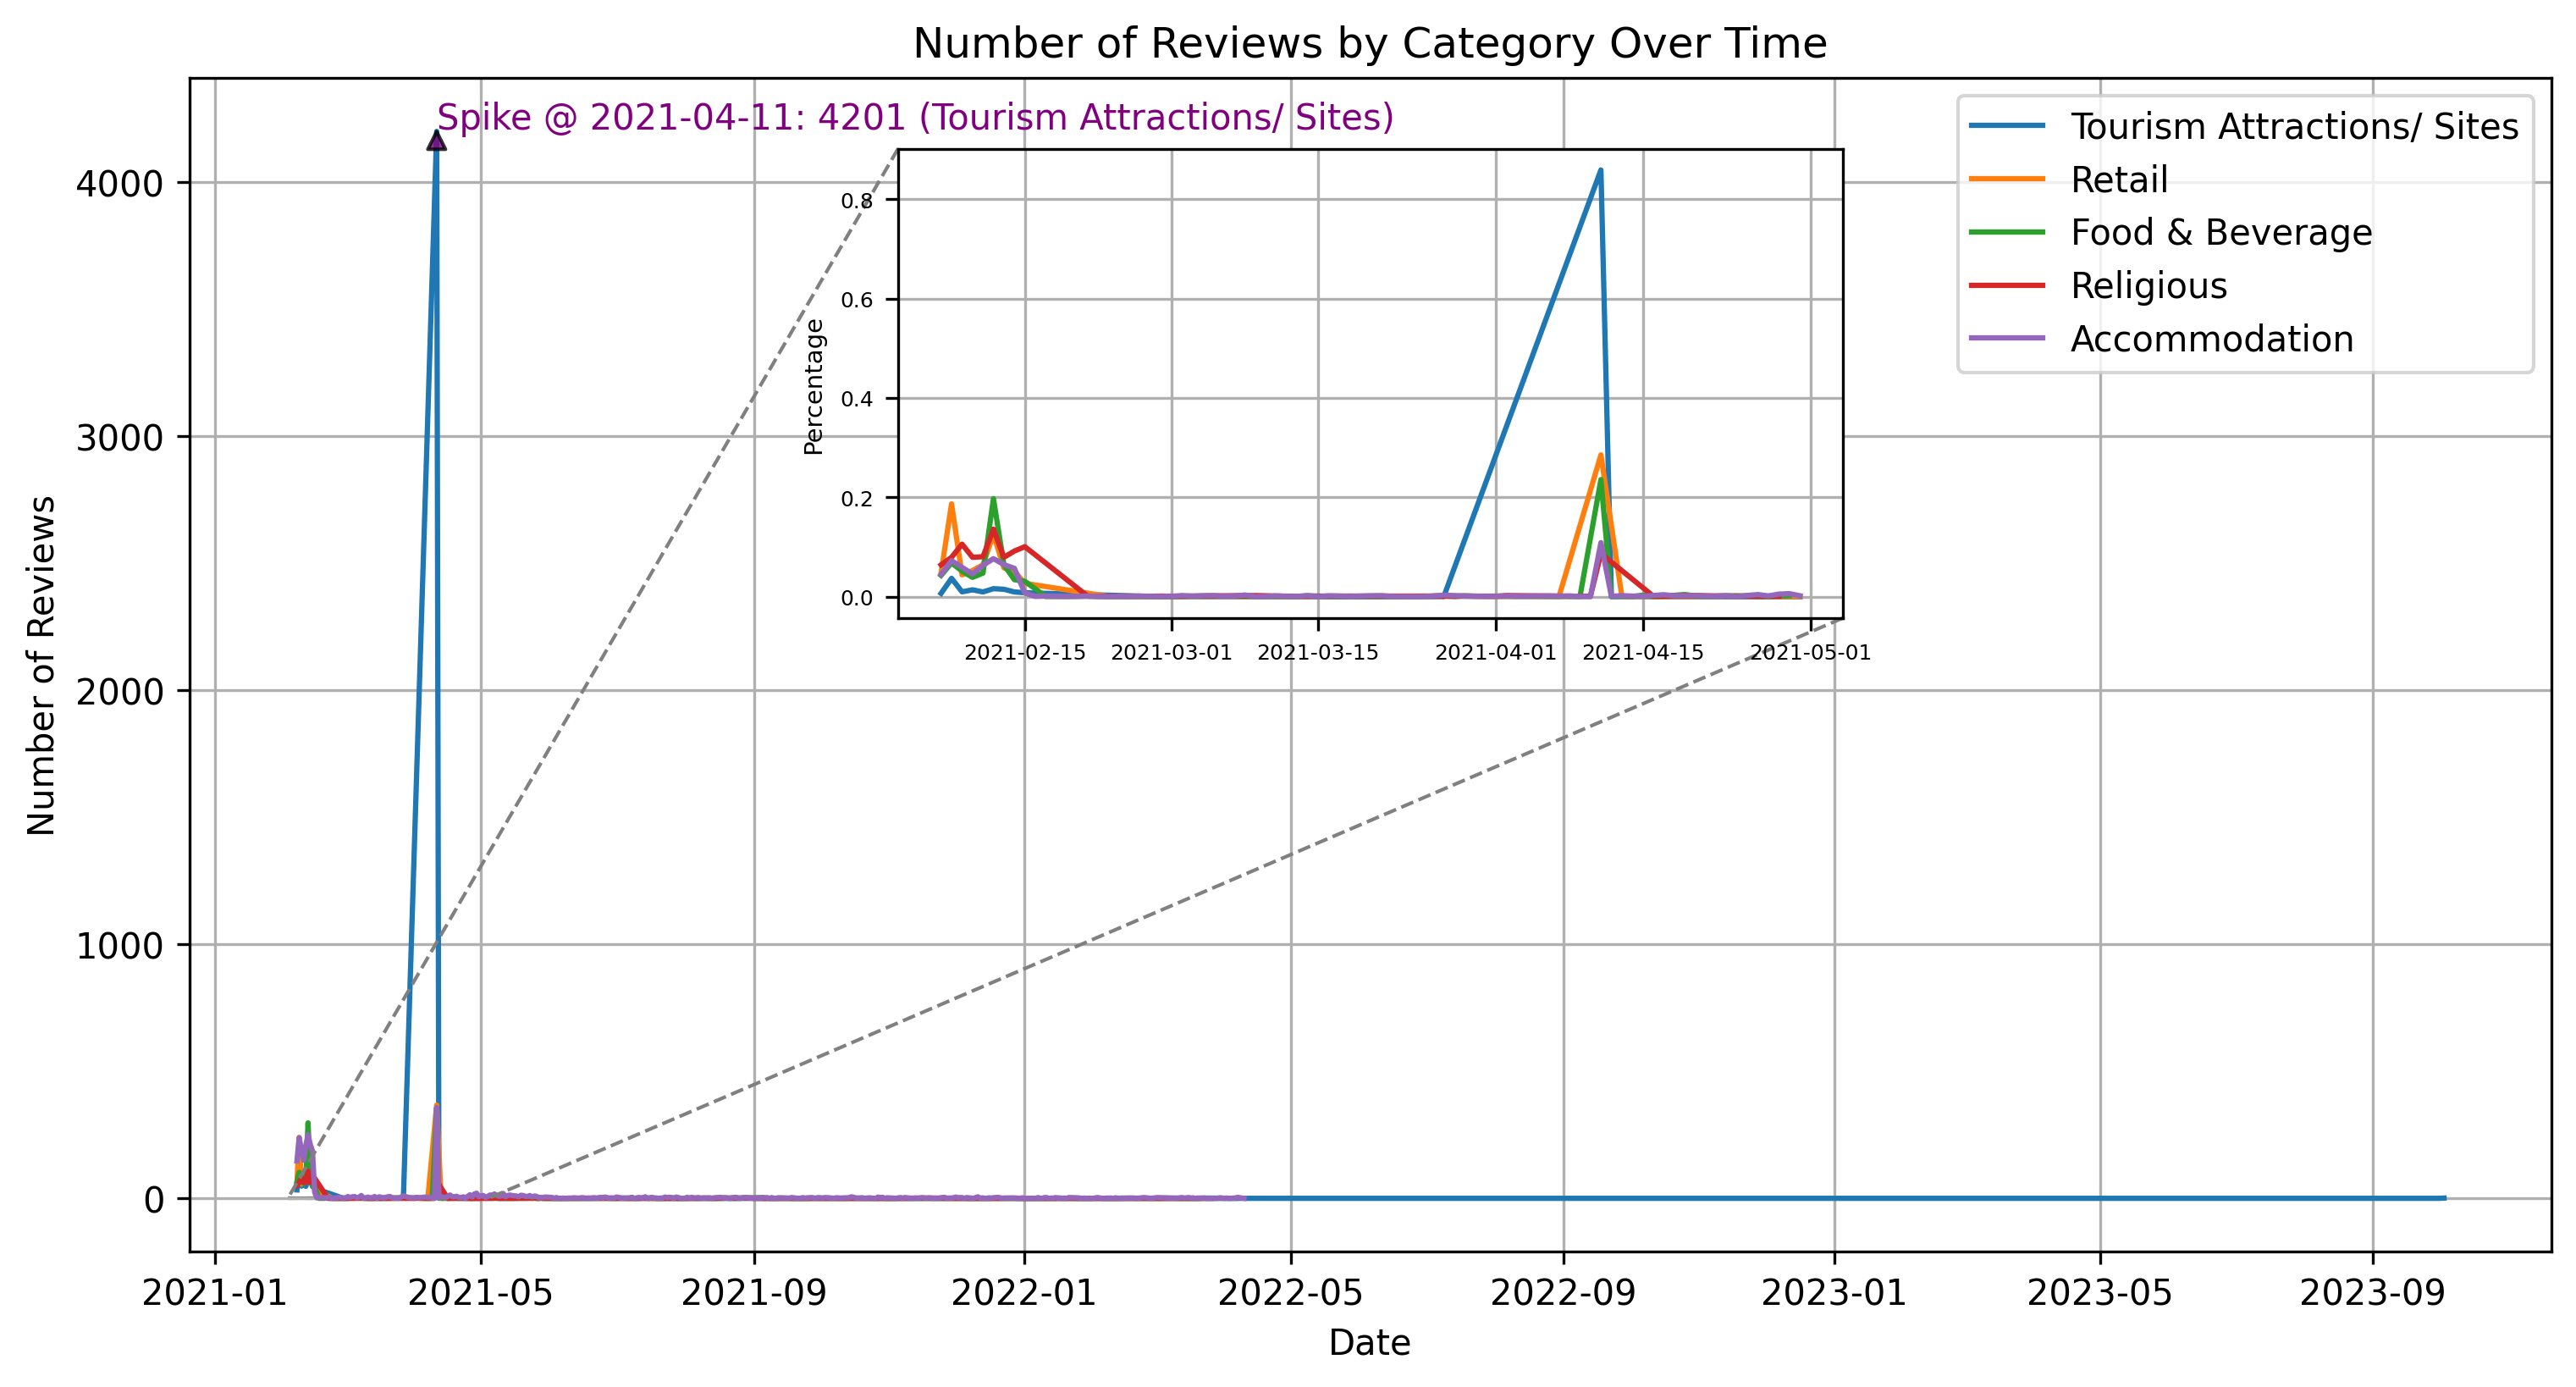

In [19]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

global_max_value = 0
global_max_date = None
category_max = ''

for category in categories:
    filtered_reviews = df[(encoded_tags[category] == 1)]
    grouped_reviews = filtered_reviews.groupby(filtered_reviews['date'].dt.date)['id'].count()
    ax.plot(grouped_reviews.index, grouped_reviews.values, label=category)

    max_date = grouped_reviews.idxmax()
    max_value = grouped_reviews.max()

    if max_value > global_max_value:
        global_max_value = max_value
        global_max_date = max_date
        category_max = category

ax.annotate(
    f'Spike @ {global_max_date}: {global_max_value:.0f} ({category_max})',
    xy=(global_max_date, global_max_value),
    xytext=(global_max_date, global_max_value + 10),
    arrowprops=dict(
        facecolor='purple', shrink=0.05, headlength=5, headwidth=5, alpha=0.8
        ),
    color='purple'
    )

ax.set_title('Number of Reviews by Category Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Reviews')
ax.legend()
ax.grid(True)

ax_inset = inset_axes(
    ax, width="40%", height="40%", loc='upper center', borderpad=2
    )

start_date = datetime.date(2021, 2, 1)
end_date = datetime.date(2021, 4, 30)

for category in categories:
    filtered_reviews = df[(encoded_tags[category] == 1)]
    grouped_reviews = filtered_reviews.groupby(
        filtered_reviews['date'].dt.date
        )['id'].count() / len(filtered_reviews)
    zoomed_reviews = grouped_reviews.loc[start_date:end_date]
    ax_inset.plot(zoomed_reviews.index, zoomed_reviews.values, label=category)

ax_inset.set_ylabel('Percentage', fontsize=7)
ax_inset.tick_params(axis='x', labelsize=6)
ax_inset.tick_params(axis='y', labelsize=6)
ax_inset.grid(True)

mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5", linestyle="--")

plt.savefig(
    f'{wm.root_dir_}/graphs/reviews_per_cat_over_time.png',
    bbox_inches='tight', transparent=True
    )
plt.show()


**Notes:**
- The plot makes it obvious that extracting time-related insights about the data won't be meaningful.
- The majority of the reviews lies in a window of $3$ months (`2021-02` - `2021-04`).
- There was a **huge spike** of reviews on **Apr $11^{th}$, 2021**.
- After some research, I couldn't find a _convincing reason_ behind this spike.

--------------------

## `#` Sentiment vs. Ratings

[Back to Top](#top)

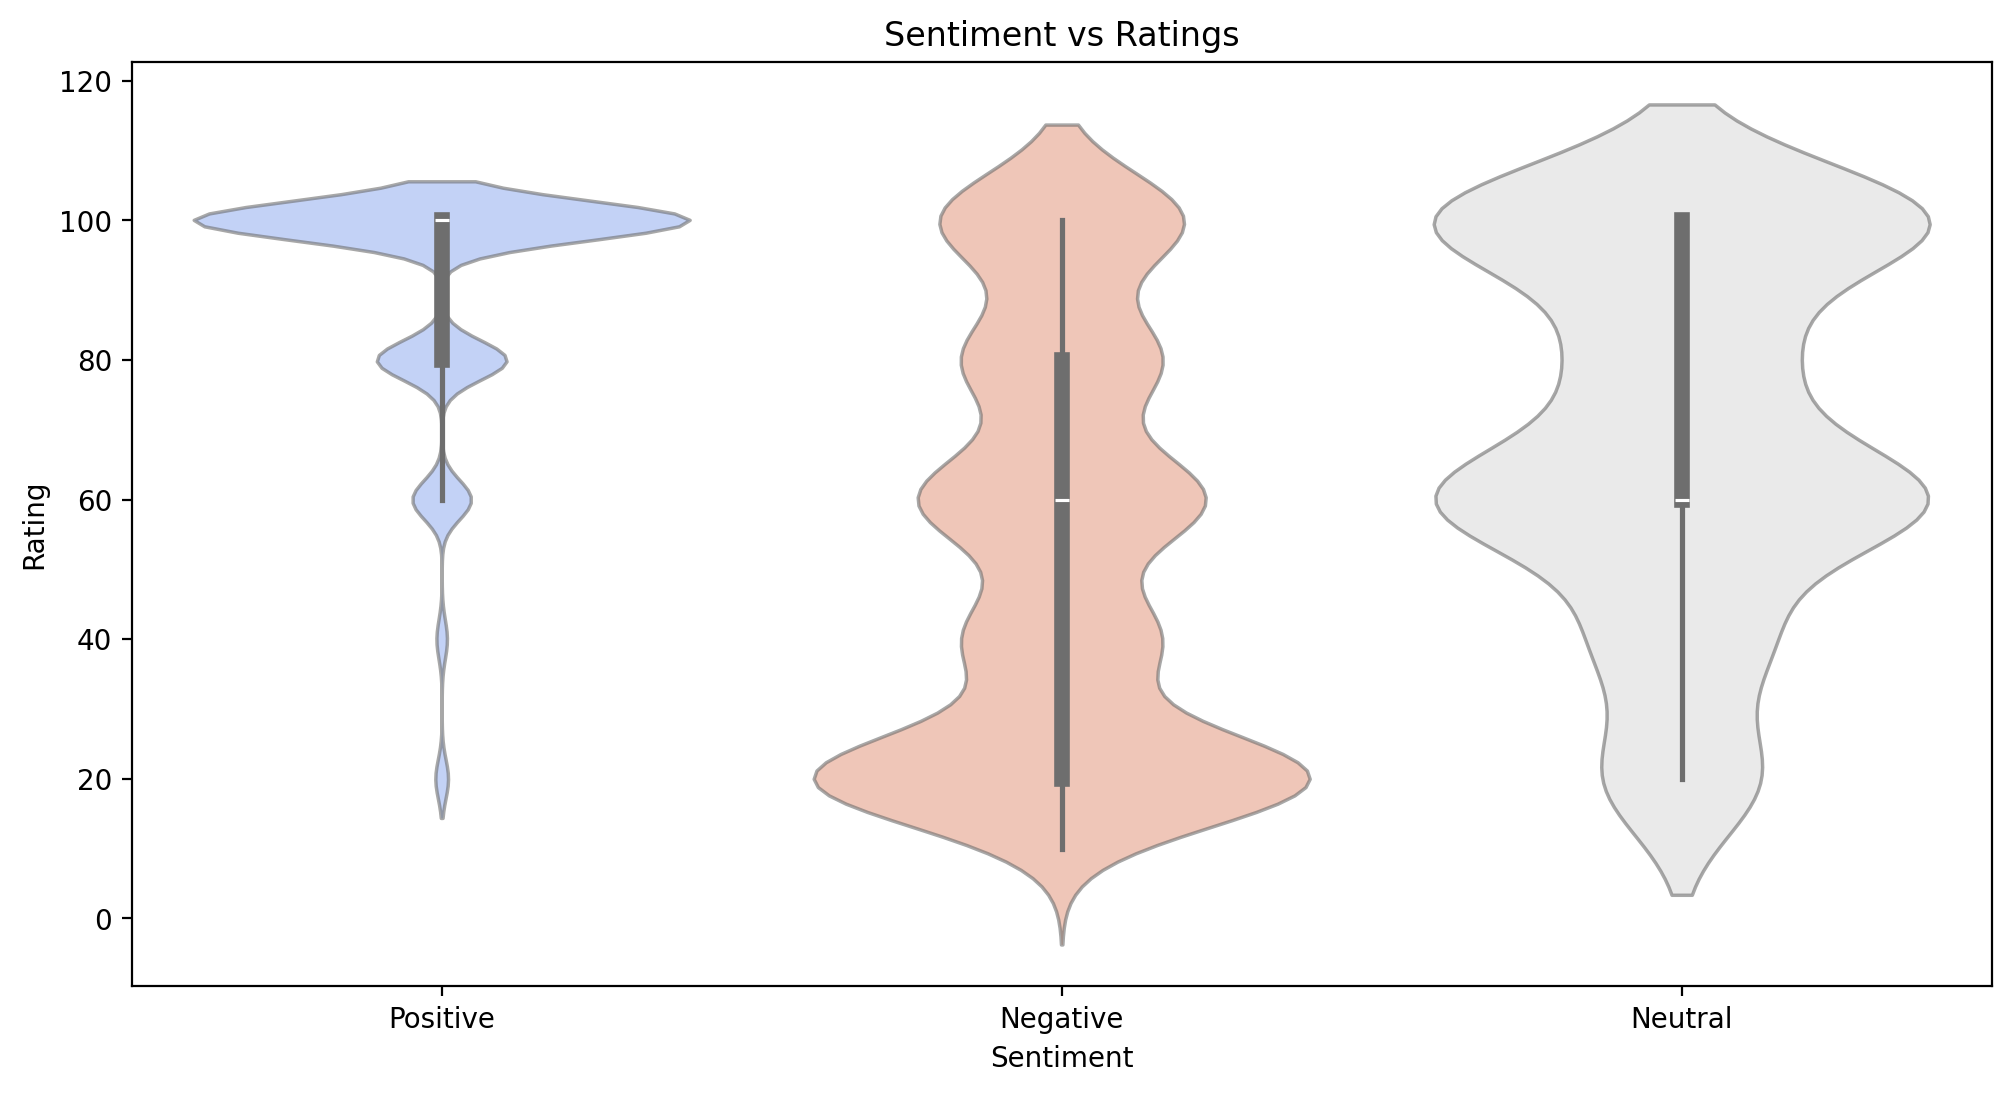

In [20]:
plt.figure(figsize=(12, 6), dpi=200)
sns.violinplot(
    y='ratings_num', x='sentiment', data=df, hue='sentiment',
    palette='coolwarm', alpha=0.6,
    hue_order=['Positive', 'Neutral', 'Negative']
    )
plt.title('Sentiment vs Ratings')
plt.xlabel('Sentiment')
plt.ylabel('Rating')

plt.savefig(
    f'{wm.root_dir_}/graphs/sentiment_vs_ratings.png',
    bbox_inches='tight', transparent=True
    )
plt.show()

**Notes:**
- The relation between _ratings_ and _sentiment_ would -ideally- be straight forward (e.g., for reviews with low ratings, sentiment would be positive or neutral).
- While most of the reviews with `Positive` _sentiment_ have high ratings, we can observe some _outliers_ below the rating of $60\%$.
- As for the reviews associated with `Neutral` _sentiment_, the distribution is slightly more spread all over the **rating scale** (almost covering $[20\%, 100\%]$).
- The strange observation is that _rating_ distribution covers the whole scale (even though it's leaning towards **low** rating values)
- This could be due to:
    - Inaccurate _sentiment_ predictions (e.g., falsely associating `Positive` _sentiment_ with a `Negative` review).
    - Inconsistent/ Mixed user input (e.g., giving low rating score while mixing negative and positive _sentiments_ in the review and confusing the **sentiment model**.

----
## `#` Distribution of Ratings

[Back to Top](#top)

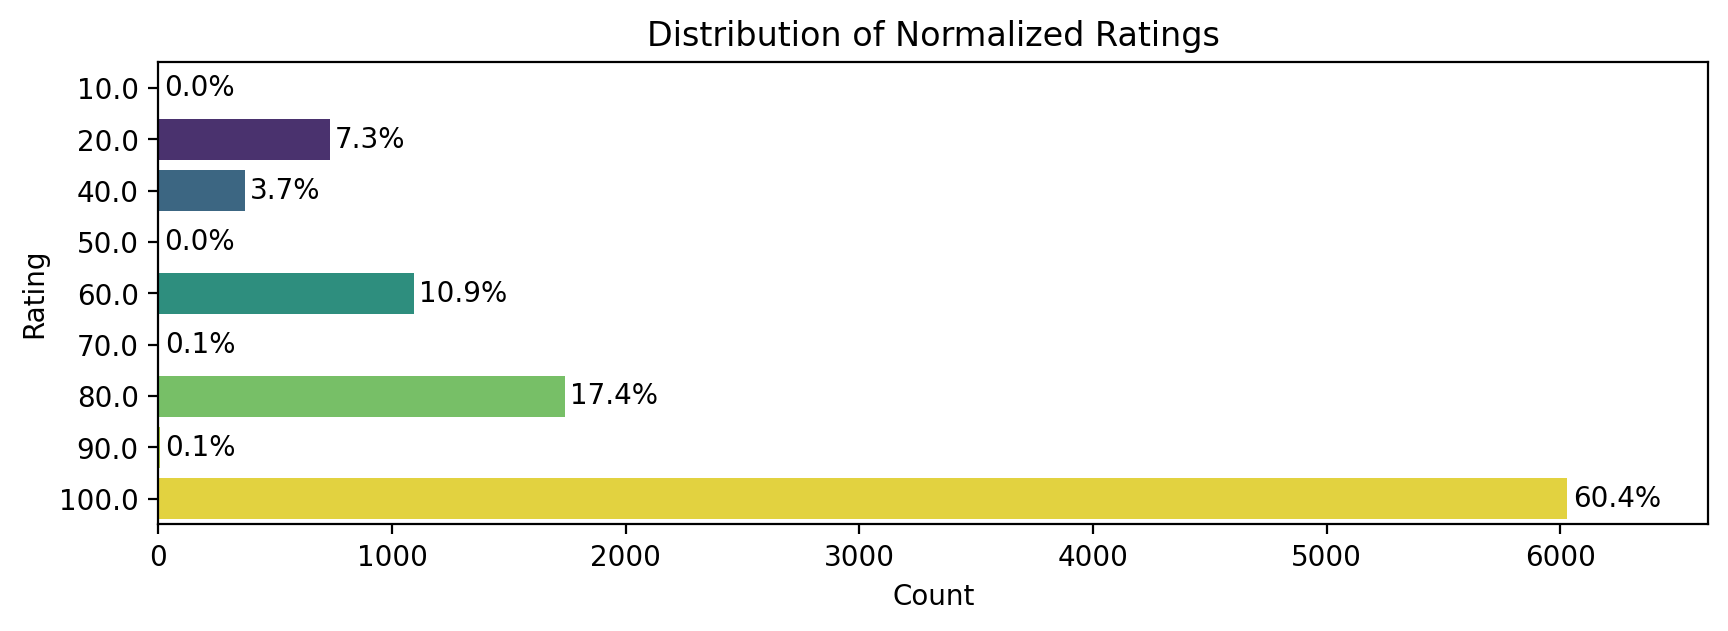

In [21]:
plt.figure(figsize=(10, 3), dpi=200)
ax = sns.countplot(df, y='ratings_num', palette='viridis', hue='ratings_num')

for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f'{(x/df.shape[0])*100:0.1f}%', padding=2)
ax.margins(x=0.1)

plt.title('Distribution of Normalized Ratings')
plt.xlabel('Count')
plt.ylabel('Rating')
plt.legend().remove()

plt.savefig(
    f'{wm.root_dir_}/graphs/normalized_ratings_dist.png',
    bbox_inches='tight', transparent=True
    )
plt.show()

**Notes:**
- The majority ($89\%$) of the reviews have high rating scores ($\ge 60\%$).
- More than $60\%$ got perfect score ($100\%$) even.

----
## `#` Distribution of Sentiments

[Back to Top](#top)

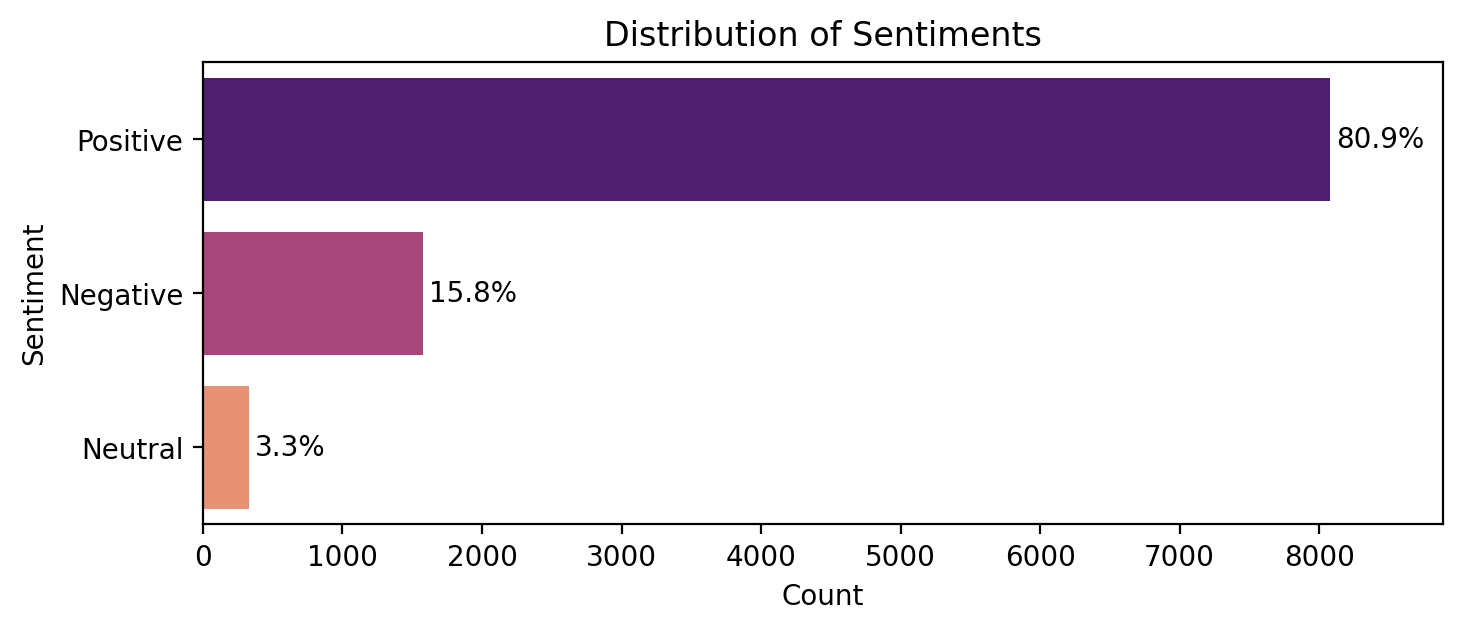

In [22]:
plt.figure(figsize=(8, 3), dpi=200)
ax = sns.countplot(df, y='sentiment', palette='magma', hue='sentiment')

for container in ax.containers:
    ax.bar_label(
        container, fmt=lambda x: f'{(x/df.shape[0])*100:0.1f}%', padding=2
        )
ax.margins(x=0.1)

plt.title('Distribution of Sentiments')
plt.xlabel('Count')
plt.ylabel('Sentiment')

plt.savefig(
    f'{wm.root_dir_}/graphs/sentiment_dist.png',
    bbox_inches='tight', transparent=True
    )
plt.show()

**Notes:**
- The vast majority ($80.9\%$) of the _sentiment_ predictions belongs to the `Positive` class.
- I might ***not*** be able to verify the _prediction accuracy_, however, I am not surprised upon seeing the distribution; since the majority of the _rating_ scores are **high**.

--------------
## `#` Sentiment Distribution by Category

[Back to Top](#top)

In [24]:
df[categories] = encoded_tags[categories]
sentiment_by_category = df.groupby('sentiment')[categories].sum().T
sentiment_by_category_norm = sentiment_by_category.div(
                            sentiment_by_category.sum(axis=1), axis=0
                            ).reset_index(drop=False)\
                            .rename(columns={'index': 'category'})
sentiment_by_category_melt = sentiment_by_category_norm.melt(
    id_vars=["category"], var_name="sentiment", value_name="count"
    )

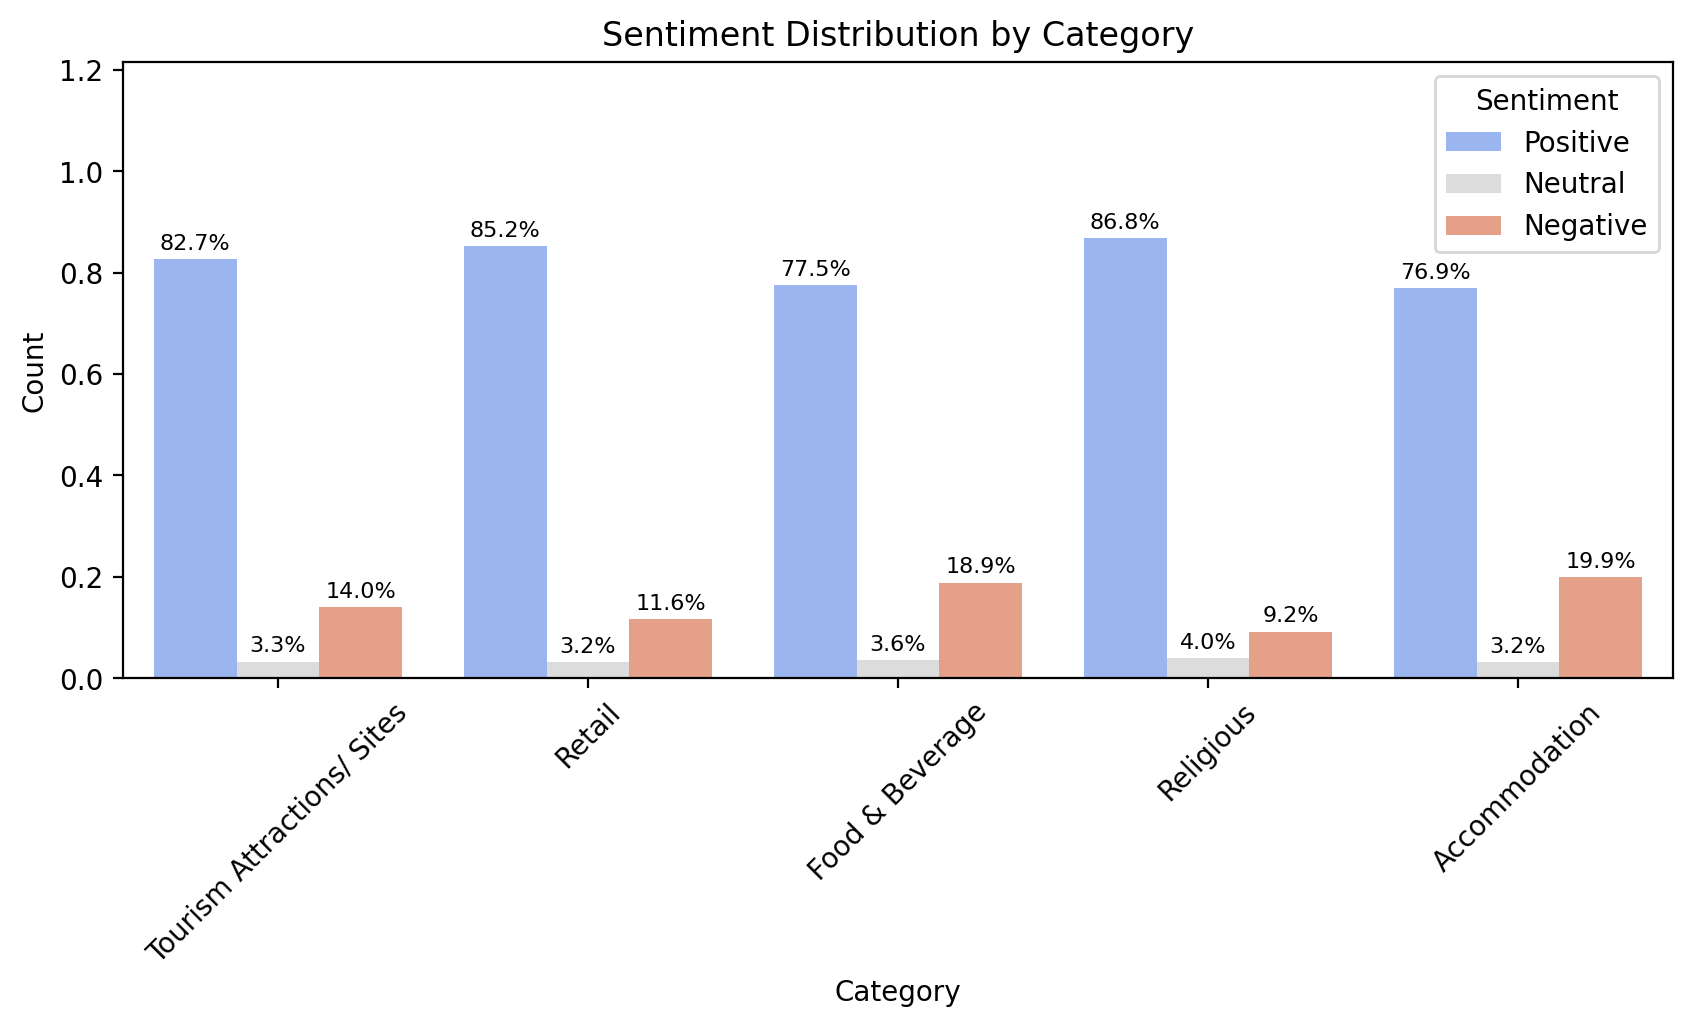

In [25]:
plt.figure(figsize=(10, 4), dpi=200)

ax = sns.barplot(x="category", y="count", hue="sentiment",
            data=sentiment_by_category_melt, palette='coolwarm',
            hue_order=['Positive', 'Neutral', 'Negative'])

for container in ax.containers:
    ax.bar_label(
        container, fmt=lambda x: f'{(x)*100:0.1f}%', padding=2, fontsize=8
        )
ax.margins(y=0.4)

plt.title("Sentiment Distribution by Category")
plt.ylabel("Count")
plt.xlabel("Category")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)

plt.savefig(
    f'{wm.root_dir_}/graphs/sentiment_dist_by_cat.png',
    bbox_inches='tight', transparent=True
    )
plt.show()


**Notes:**
- There is nothing special that can be extracted from this plot.
- The distribution of _sentiments_ is almost ***similar*** among different categories (and similar to the **global distribuion** of _sentiment_).
- It might be worth mentioning that reviews associated with `Religious` category have a **slightly** lower `Negative` _sentiment_ than other categories.

----
## `#` Sentiment Distribution by City

[Back to Top](#top)

In [26]:
df[cities] = encoded_tags[cities]
sentiment_by_city = df.groupby('sentiment')[cities].sum().T
sentiment_by_city_norm = sentiment_by_city.div(
                            sentiment_by_city.sum(axis=1), axis=0
                            ).reset_index(drop=False)\
                            .rename(columns={'index': 'city'})
sentiment_by_city_melt = sentiment_by_city_norm.melt(
    id_vars=["city"], var_name="sentiment", value_name="count"
    )

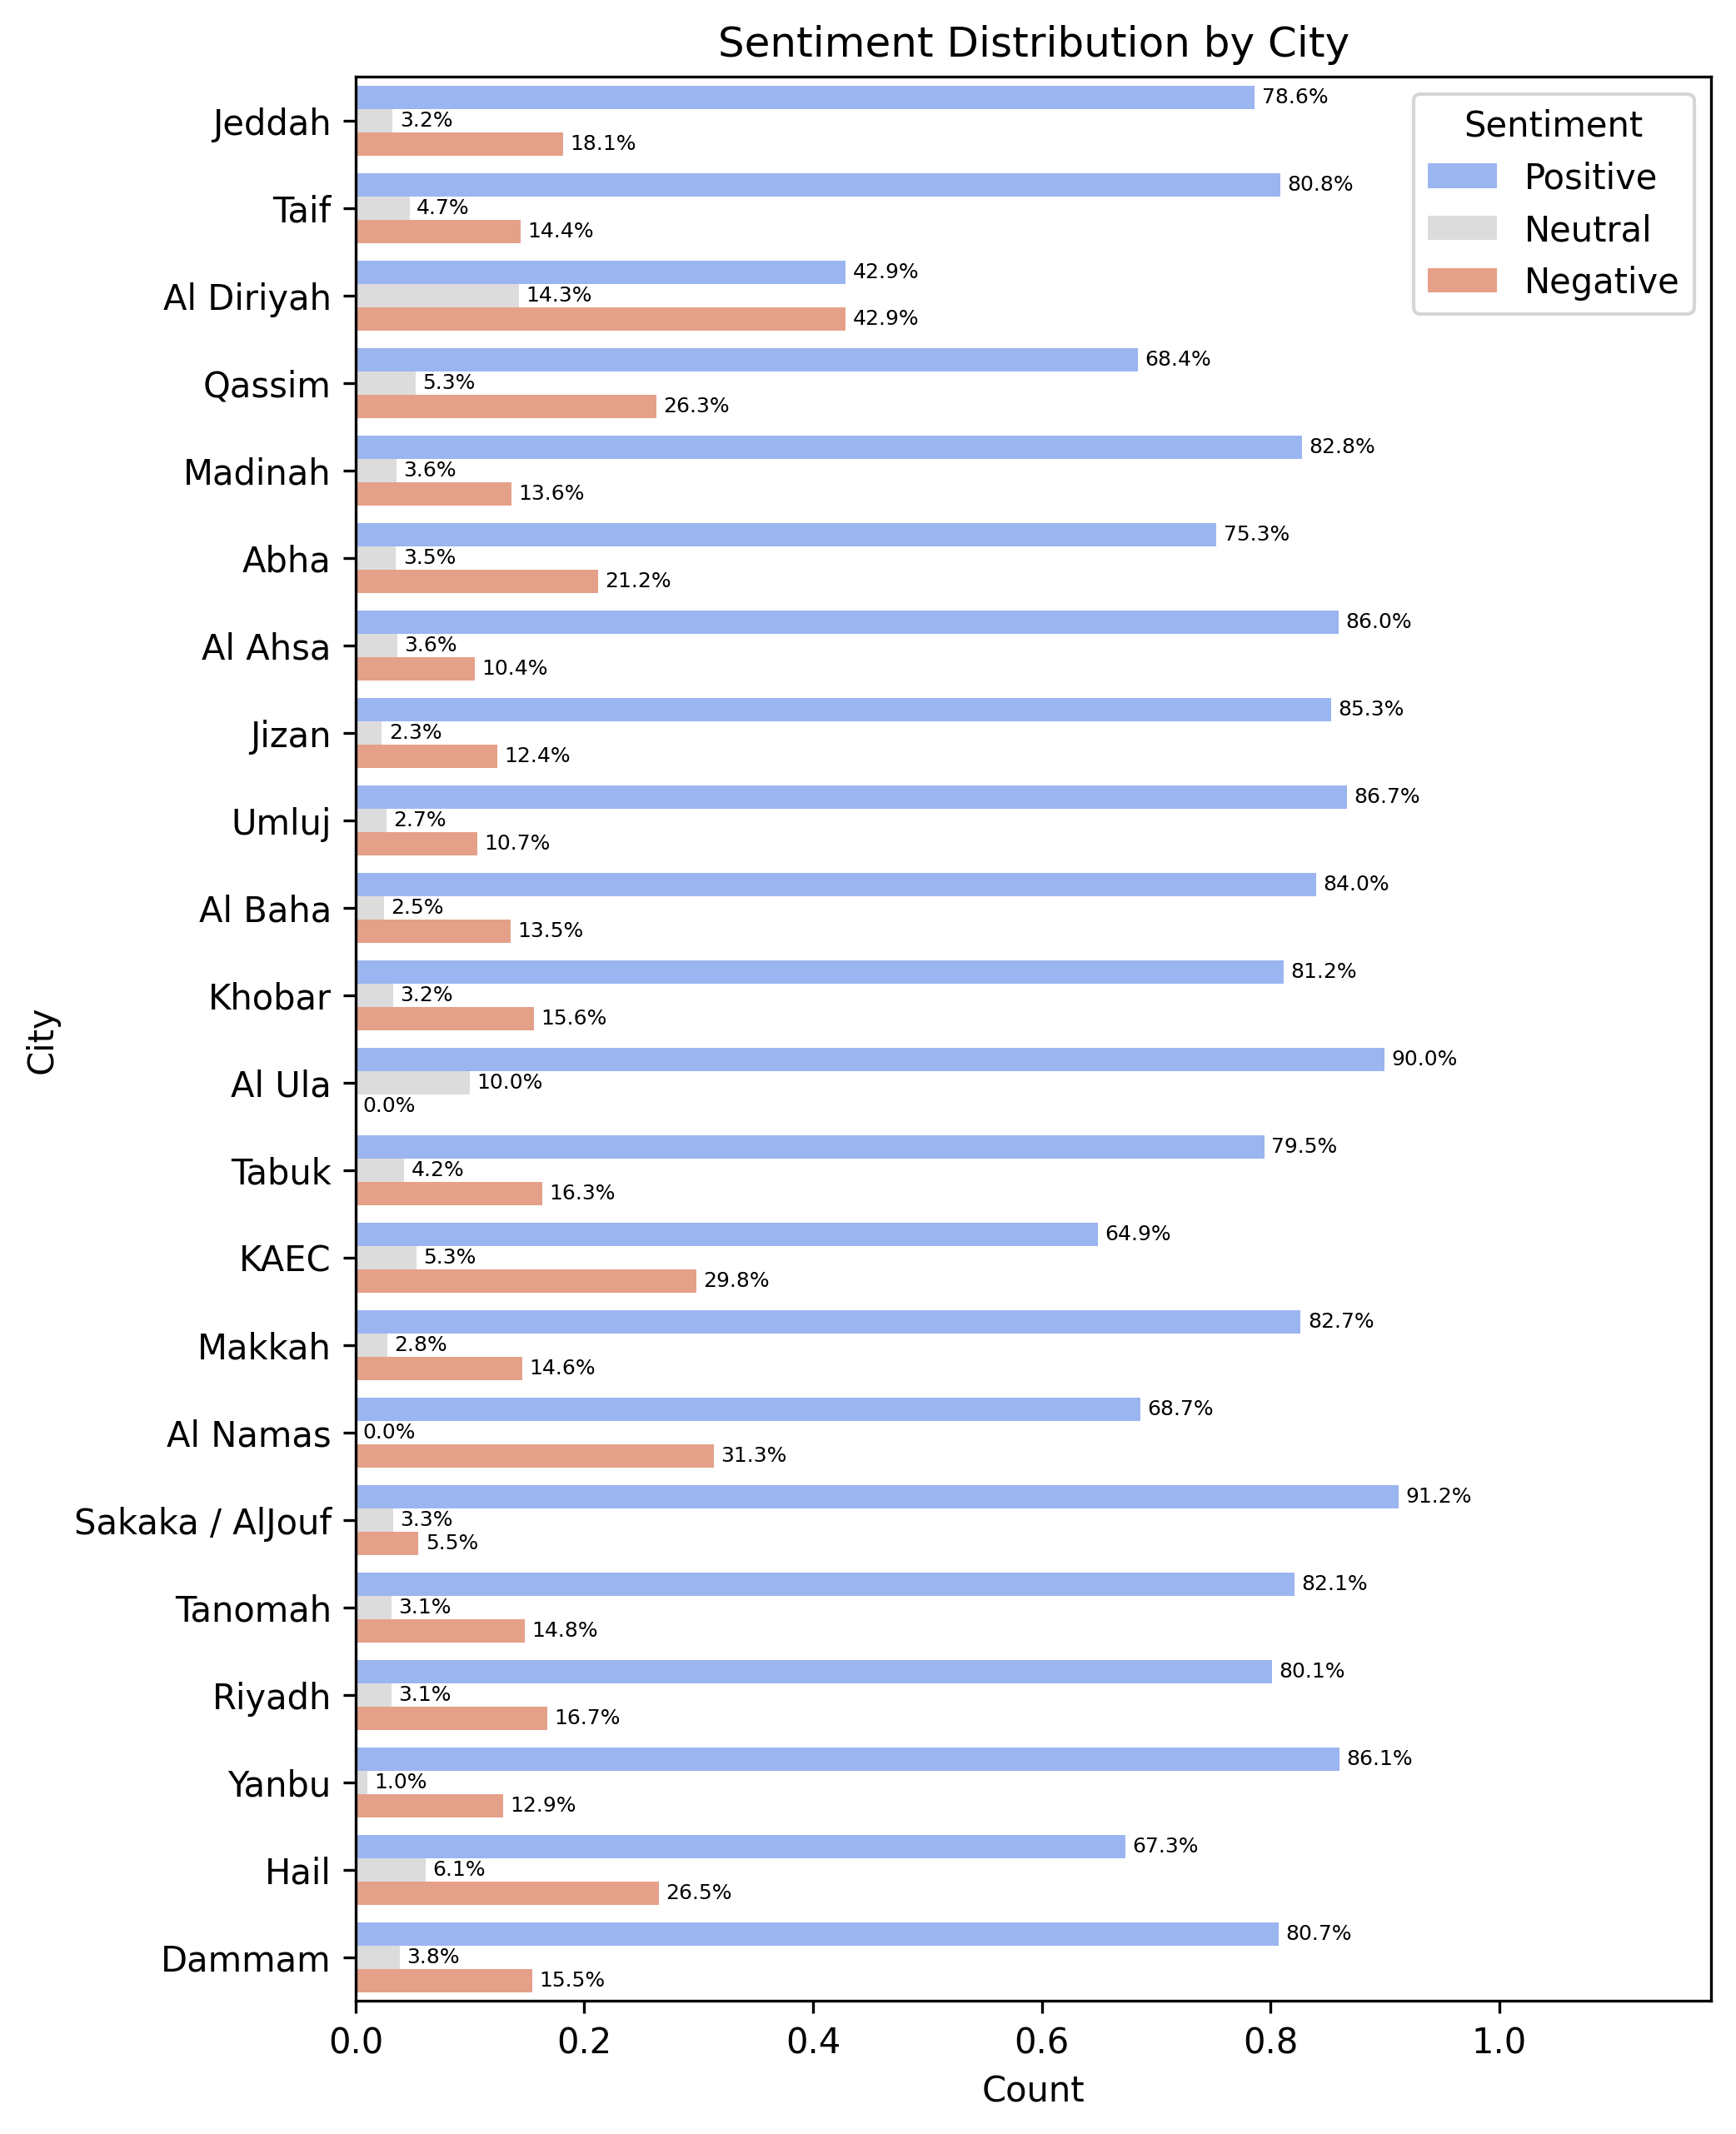

In [27]:
plt.figure(figsize=(7, 10), dpi=300)

ax = sns.barplot(y="city", x="count", hue="sentiment",
            data=sentiment_by_city_melt, palette='coolwarm',
            hue_order=['Positive', 'Neutral', 'Negative'])

for container in ax.containers:
    ax.bar_label(
        container, fmt=lambda x: f'{x*100:0.1f}%', padding=2, fontsize=6
        )
ax.margins(x=0.3)

plt.title("Sentiment Distribution by City")
plt.xlabel("Count")
plt.ylabel("City")
plt.legend(title="Sentiment")

plt.savefig(
    f'{wm.root_dir_}/graphs/sentiment_dist_by_city.png',
    bbox_inches='tight', transparent=True
    )
plt.show()


**Notes:**
- The same can be said about the _sentiment_ distribution by city. It is fairly as expexted.
- The only anomalies one point out are:
    - `Al Diriyah` City
    - `Al Namas` City
    - `KAEC` (King Abdullah Economic City)
- These could only be due to the fact that the number of reviews associated with these cities is small ($\approx 130$ review at most with `Al Diriyah` having only $7$).

----
## `#` Distribution of Themes

[Back to Top](#top)

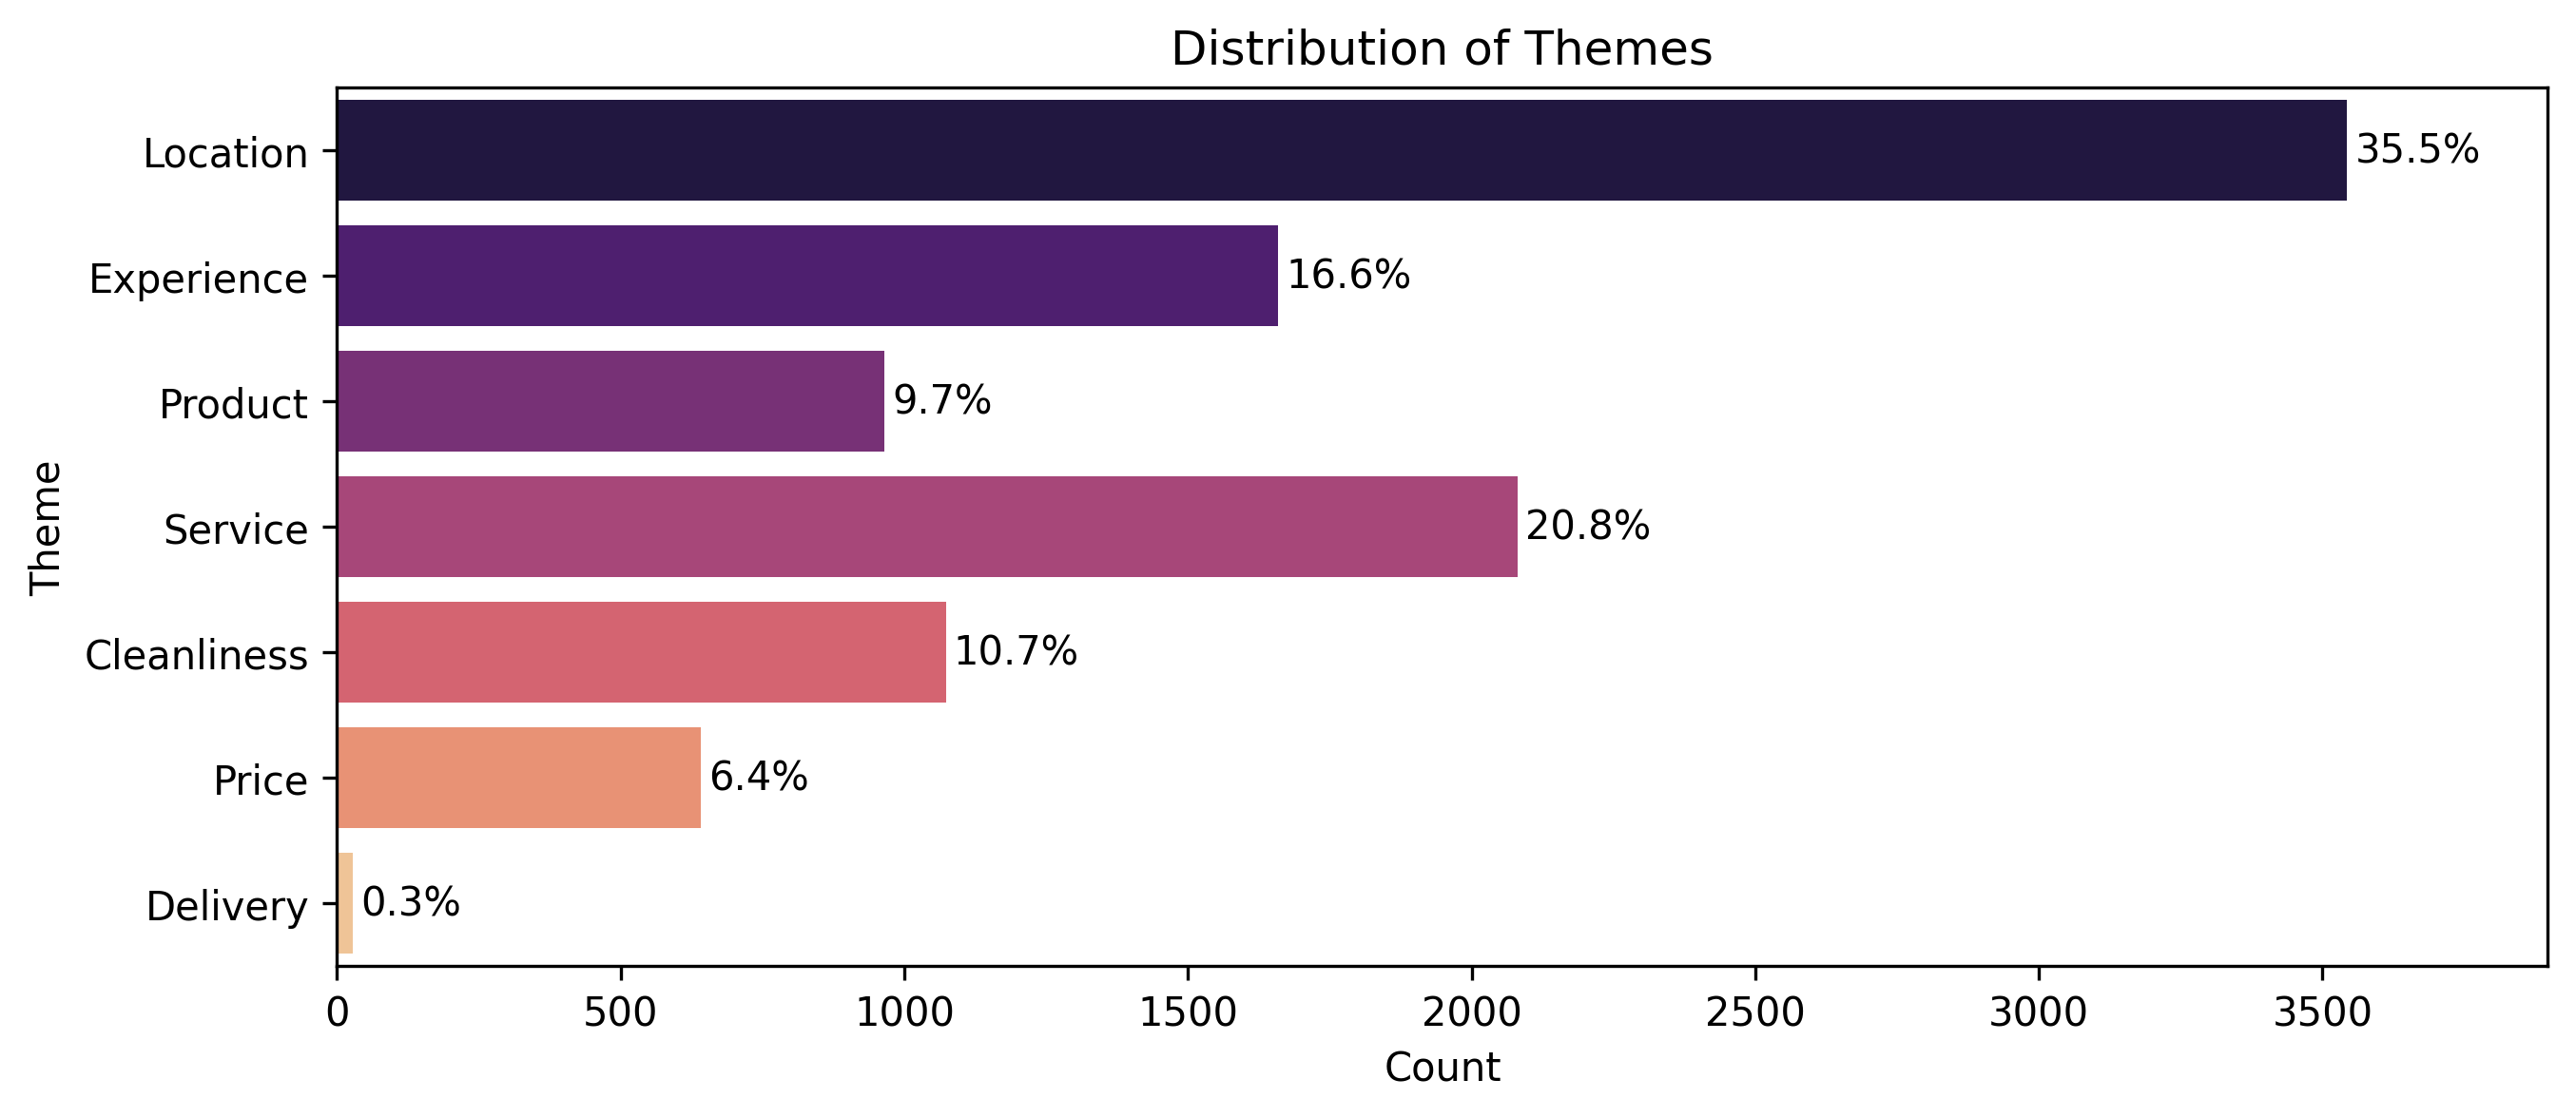

In [28]:
plt.figure(figsize=(10, 4), dpi=300)
ax = sns.countplot(df, y='combined_theme', palette='magma', hue='combined_theme')
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f'{(x/df.shape[0])*100:0.1f}%', padding=2)
ax.margins(x=0.1)

plt.title('Distribution of Themes')
plt.xlabel('Count')
plt.ylabel('Theme')

plt.savefig(
    f'{wm.root_dir_}/graphs/themes_dist.png',
    bbox_inches='tight', transparent=True
    )
plt.show()

**Notes:**
- These themes might be manually crafted and there could be _better candidate classes_ to be used out there, however, I can say they are okay to ***prove the point***.
- It seems that **most** of the reviews are centered around `Location`, `Service`, and `Experience`.
Which makes sense considering these are reviews that were extracted from _Google Maps_ (I assume).

-----
## `#` Distribution of Themes by Positive/ Negative Sentiment

[Back to Top](#top)

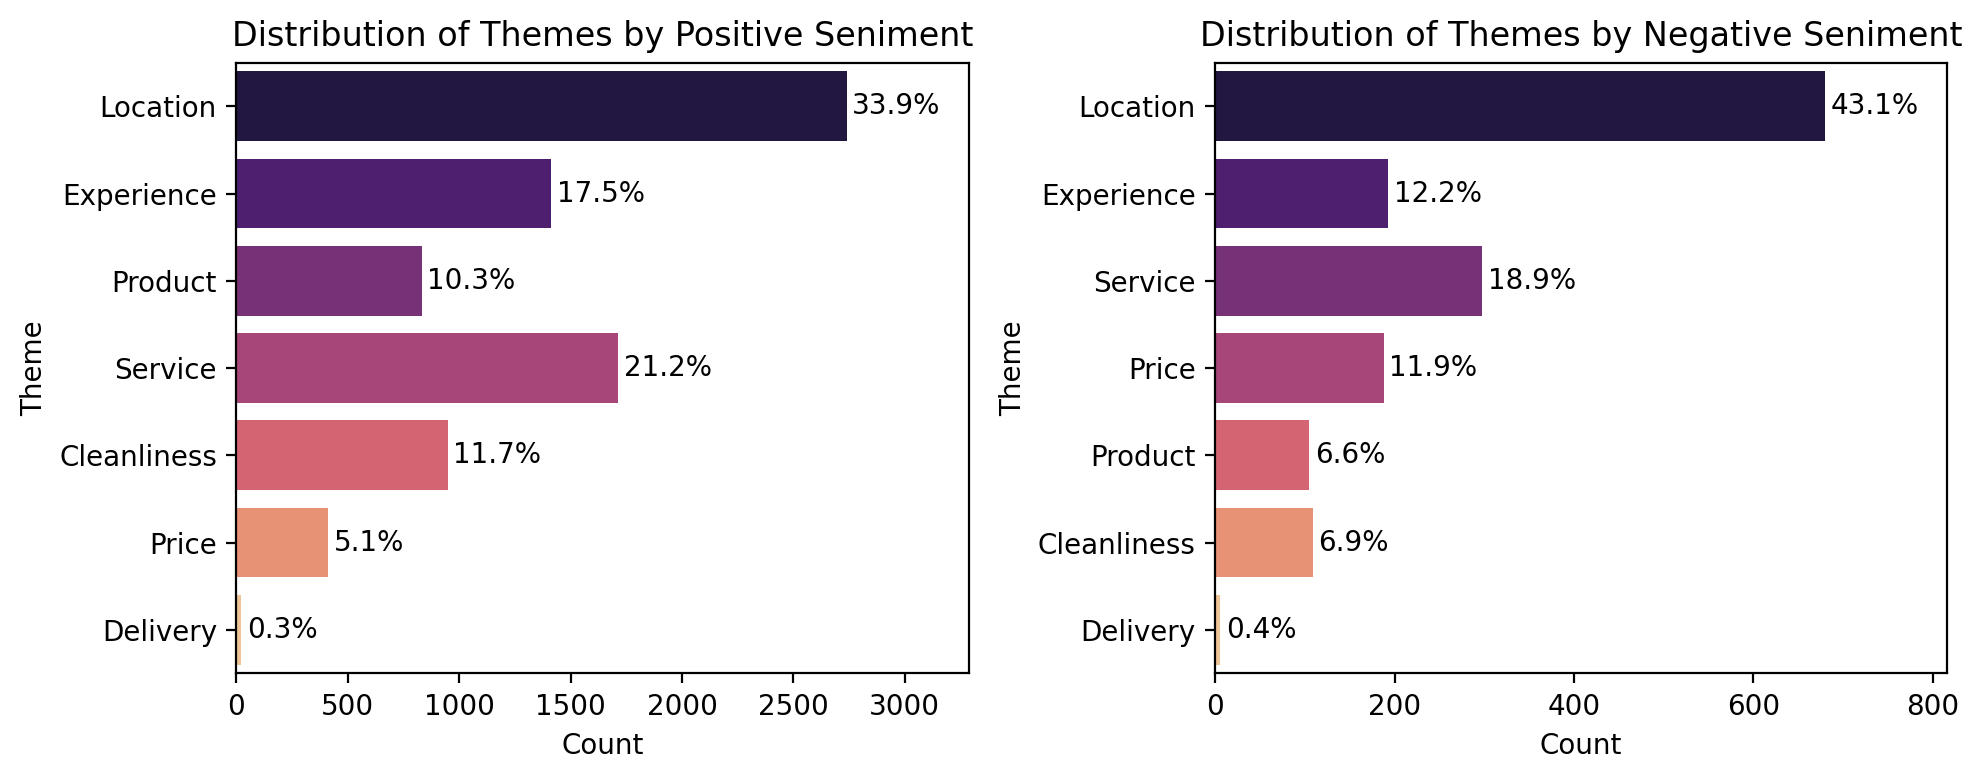

In [29]:
axes = plt.subplots(1, 2, figsize=(10, 4), dpi=200)[1].flatten()
pos_df = df[df.sentiment=='Positive']
neg_df = df[df.sentiment=='Negative']

ax1 = sns.countplot(pos_df, y='combined_theme', palette='magma', hue='combined_theme', ax=axes[0])
for container in ax1.containers:
    ax1.bar_label(container, fmt=lambda x: f'{(x/pos_df.shape[0])*100:0.1f}%', padding=2)
ax1.margins(x=0.2)

ax1.set_title('Distribution of Themes by Positive Seniment')
ax1.set_xlabel('Count')
ax1.set_ylabel('Theme')

ax2 = sns.countplot(neg_df, y='combined_theme', palette='magma', hue='combined_theme', ax=axes[1])
for container in ax2.containers:
    ax2.bar_label(container, fmt=lambda x: f'{(x/neg_df.shape[0])*100:0.1f}%', padding=2)
ax2.margins(x=0.2)

ax2.set_title('Distribution of Themes by Negative Seniment')
ax2.set_xlabel('Count')
ax2.set_ylabel('Theme')
plt.tight_layout()

plt.savefig(
    f'{wm.root_dir_}/graphs/themes_dist_by_sentiment.png',
    bbox_inches='tight', transparent=True
    )
plt.show()

**Notes:**
- For a second, it seemed that _theme_ distribution is _somewhat_ similar between reviews associated `Positive` and `Negative` _sentiments_.
- However, there two important observations:
    - The percentage of `Positive` reviews tagged with `cleanliness`  ($11.7\%$) is _almost double_ the percentage of `Negative` reviews.
    - On the other hand, `Negative` reviews percentage associated with `price` _theme_ is **more than double** its value for `Positive`ones.
- There are other considerations, of course, such as the difference in numbers between `Negative` and `Positive` reviews and _sentiment prediction accuracy_.
- But, the observations still make sense since:
    - High `Price` is a common reason for `Negative` customer feedback.
    - `Cleanliness` is a critical basis for `Positive` feedback.

-----
## `#` Most Frequent Categories/ Cities

[Back to Top](#top)

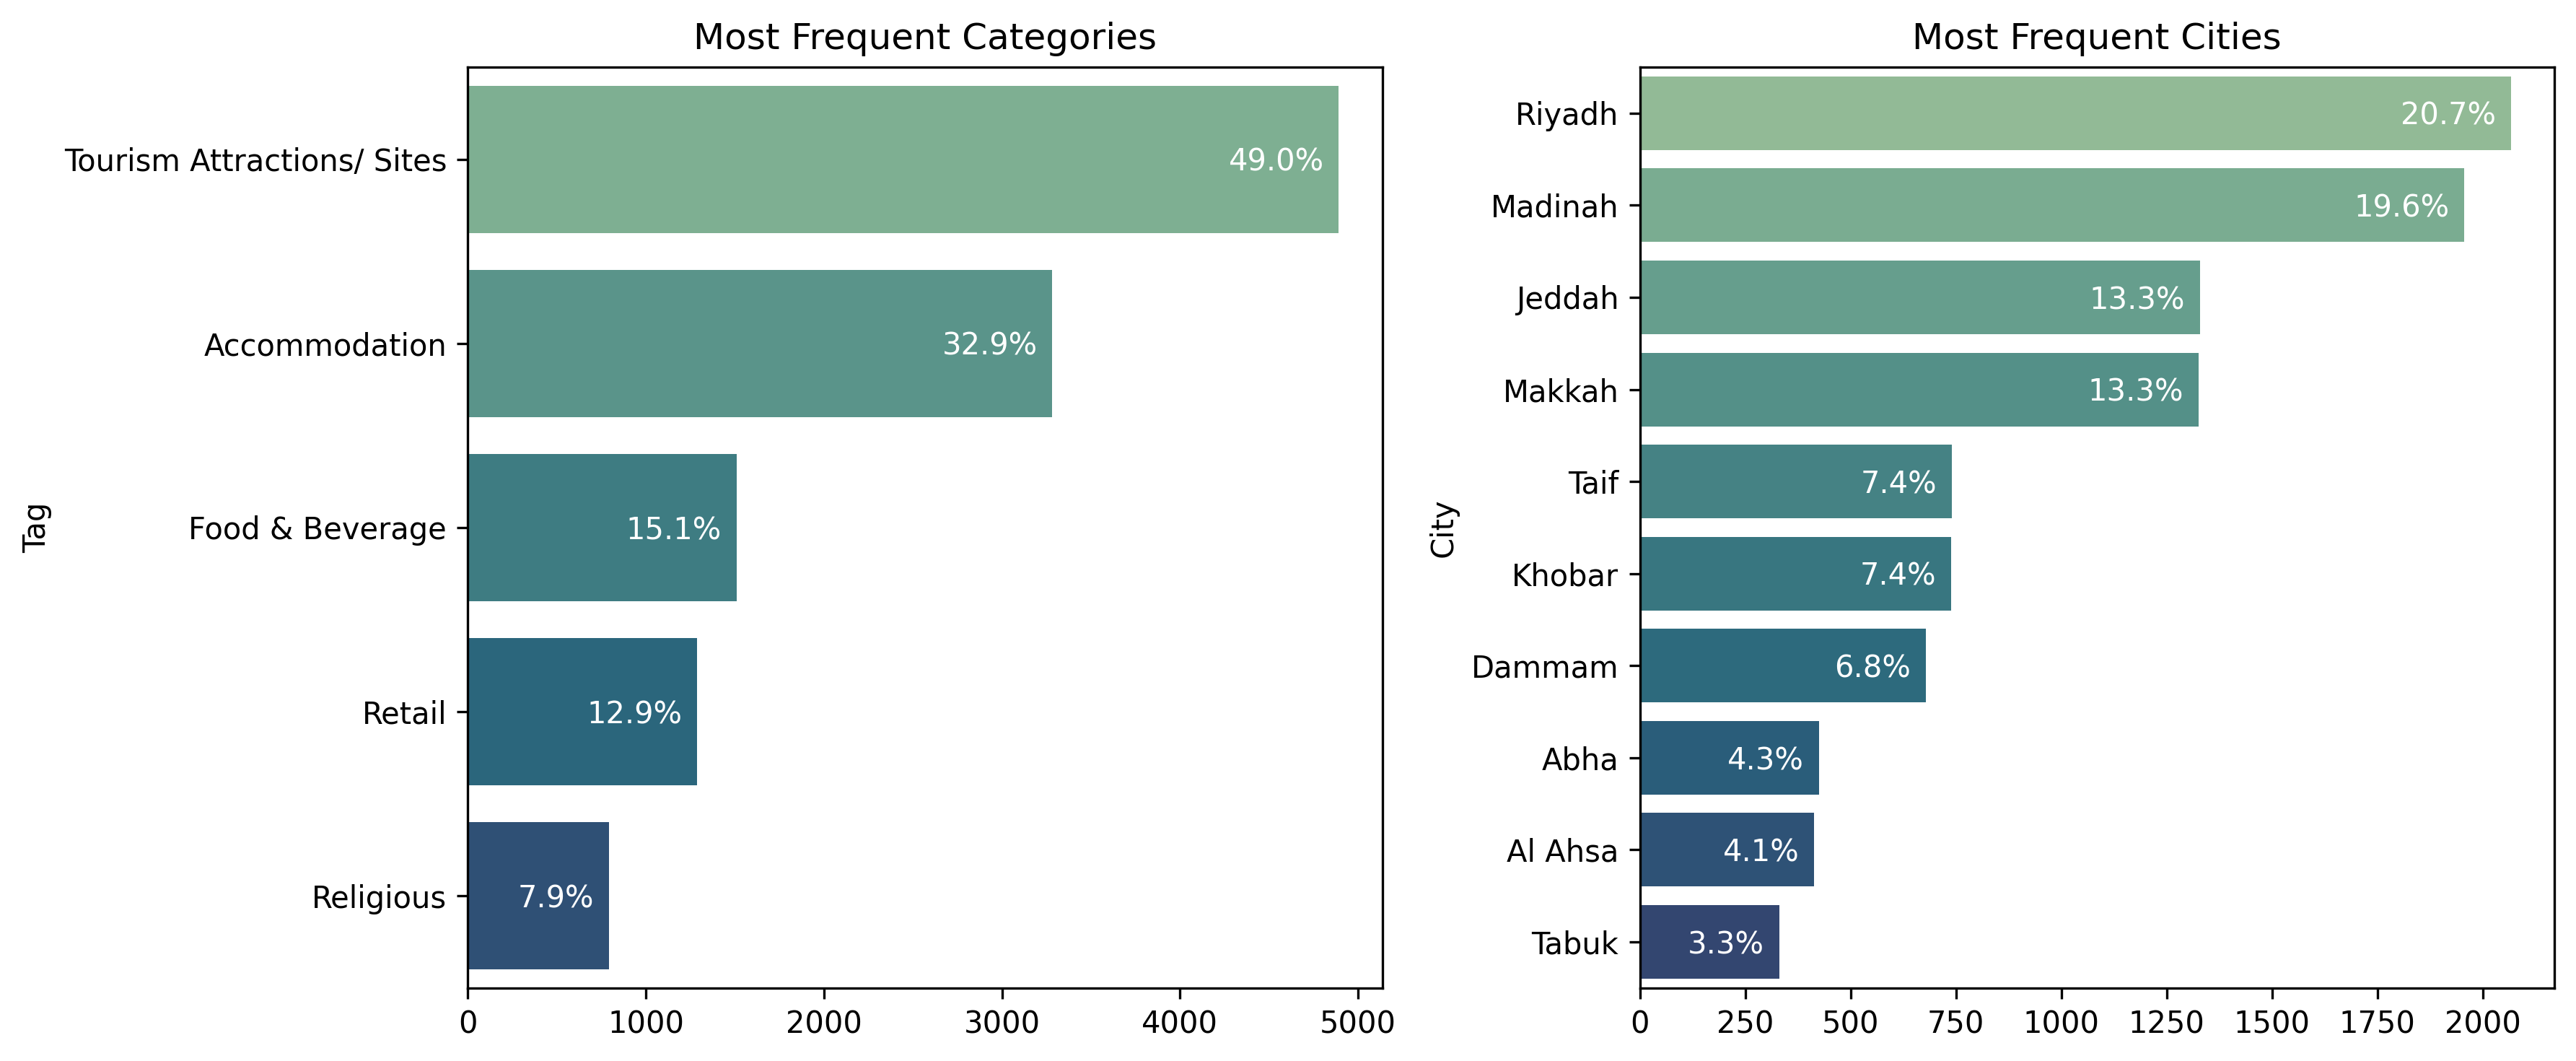

In [30]:
top_categories = encoded_tags[categories].sum().sort_values(ascending=False)[:10]
top_cities = encoded_tags[cities].sum().sort_values(ascending=False)[:10]

_, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

sns.barplot(x=top_categories.values, y=top_categories.index, ax=axes[0], hue=top_categories.index, palette='crest')
axes[0].set_title("Most Frequent Categories")
axes[0].set_ylabel('Tag')
for i in range(len(top_categories)):
    value = top_categories.values[i]
    percentage = value / df.shape[0] * 100
    axes[0].annotate(f'{percentage:.1f}%', xy=(value, i), xytext=(-5, -1), textcoords='offset points', ha='right', va='center', color='white')

sns.barplot(x=top_cities.values, y=top_cities.index, ax=axes[1], hue=top_cities.index, palette='crest')
axes[1].set_title("Most Frequent Cities")
axes[1].set_ylabel('City')
for i in range(len(top_cities)):
    value = top_cities.values[i]
    percentage = value / df.shape[0] * 100
    axes[1].annotate(f'{percentage:.1f}%', xy=(value, i), xytext=(-5, -1), textcoords='offset points', ha='right', va='center', color='white')

plt.tight_layout()

plt.savefig(
    f'{wm.root_dir_}/graphs/most_freq_cat_city.png',
    bbox_inches='tight', transparent=True
    )
plt.show()

**Notes:**
- Most frequent categories plot shows that:
    - Almost $50\%$ of the reviews have `Tourism Attractions/ Sites` which does make sense because these are the kind of places that usually receive reviews.
    - In that same sense, `Accommodation` came second with almost $33\%$ of reviews relating to it.
- On the other hand, the most frequent cities graph shows that:
    - `Riyadh` and `Madinah` are on top with almost $20\%$.
    - `Jeddah` and `Makkah` come right after with almost identical percentage of $13.3\%$.
        It's no wonder since `Jeddah` is known as the _Gateway to Makkah_.

-----
## `#` Categories Correlation with Cities

[Back to Top](#top)

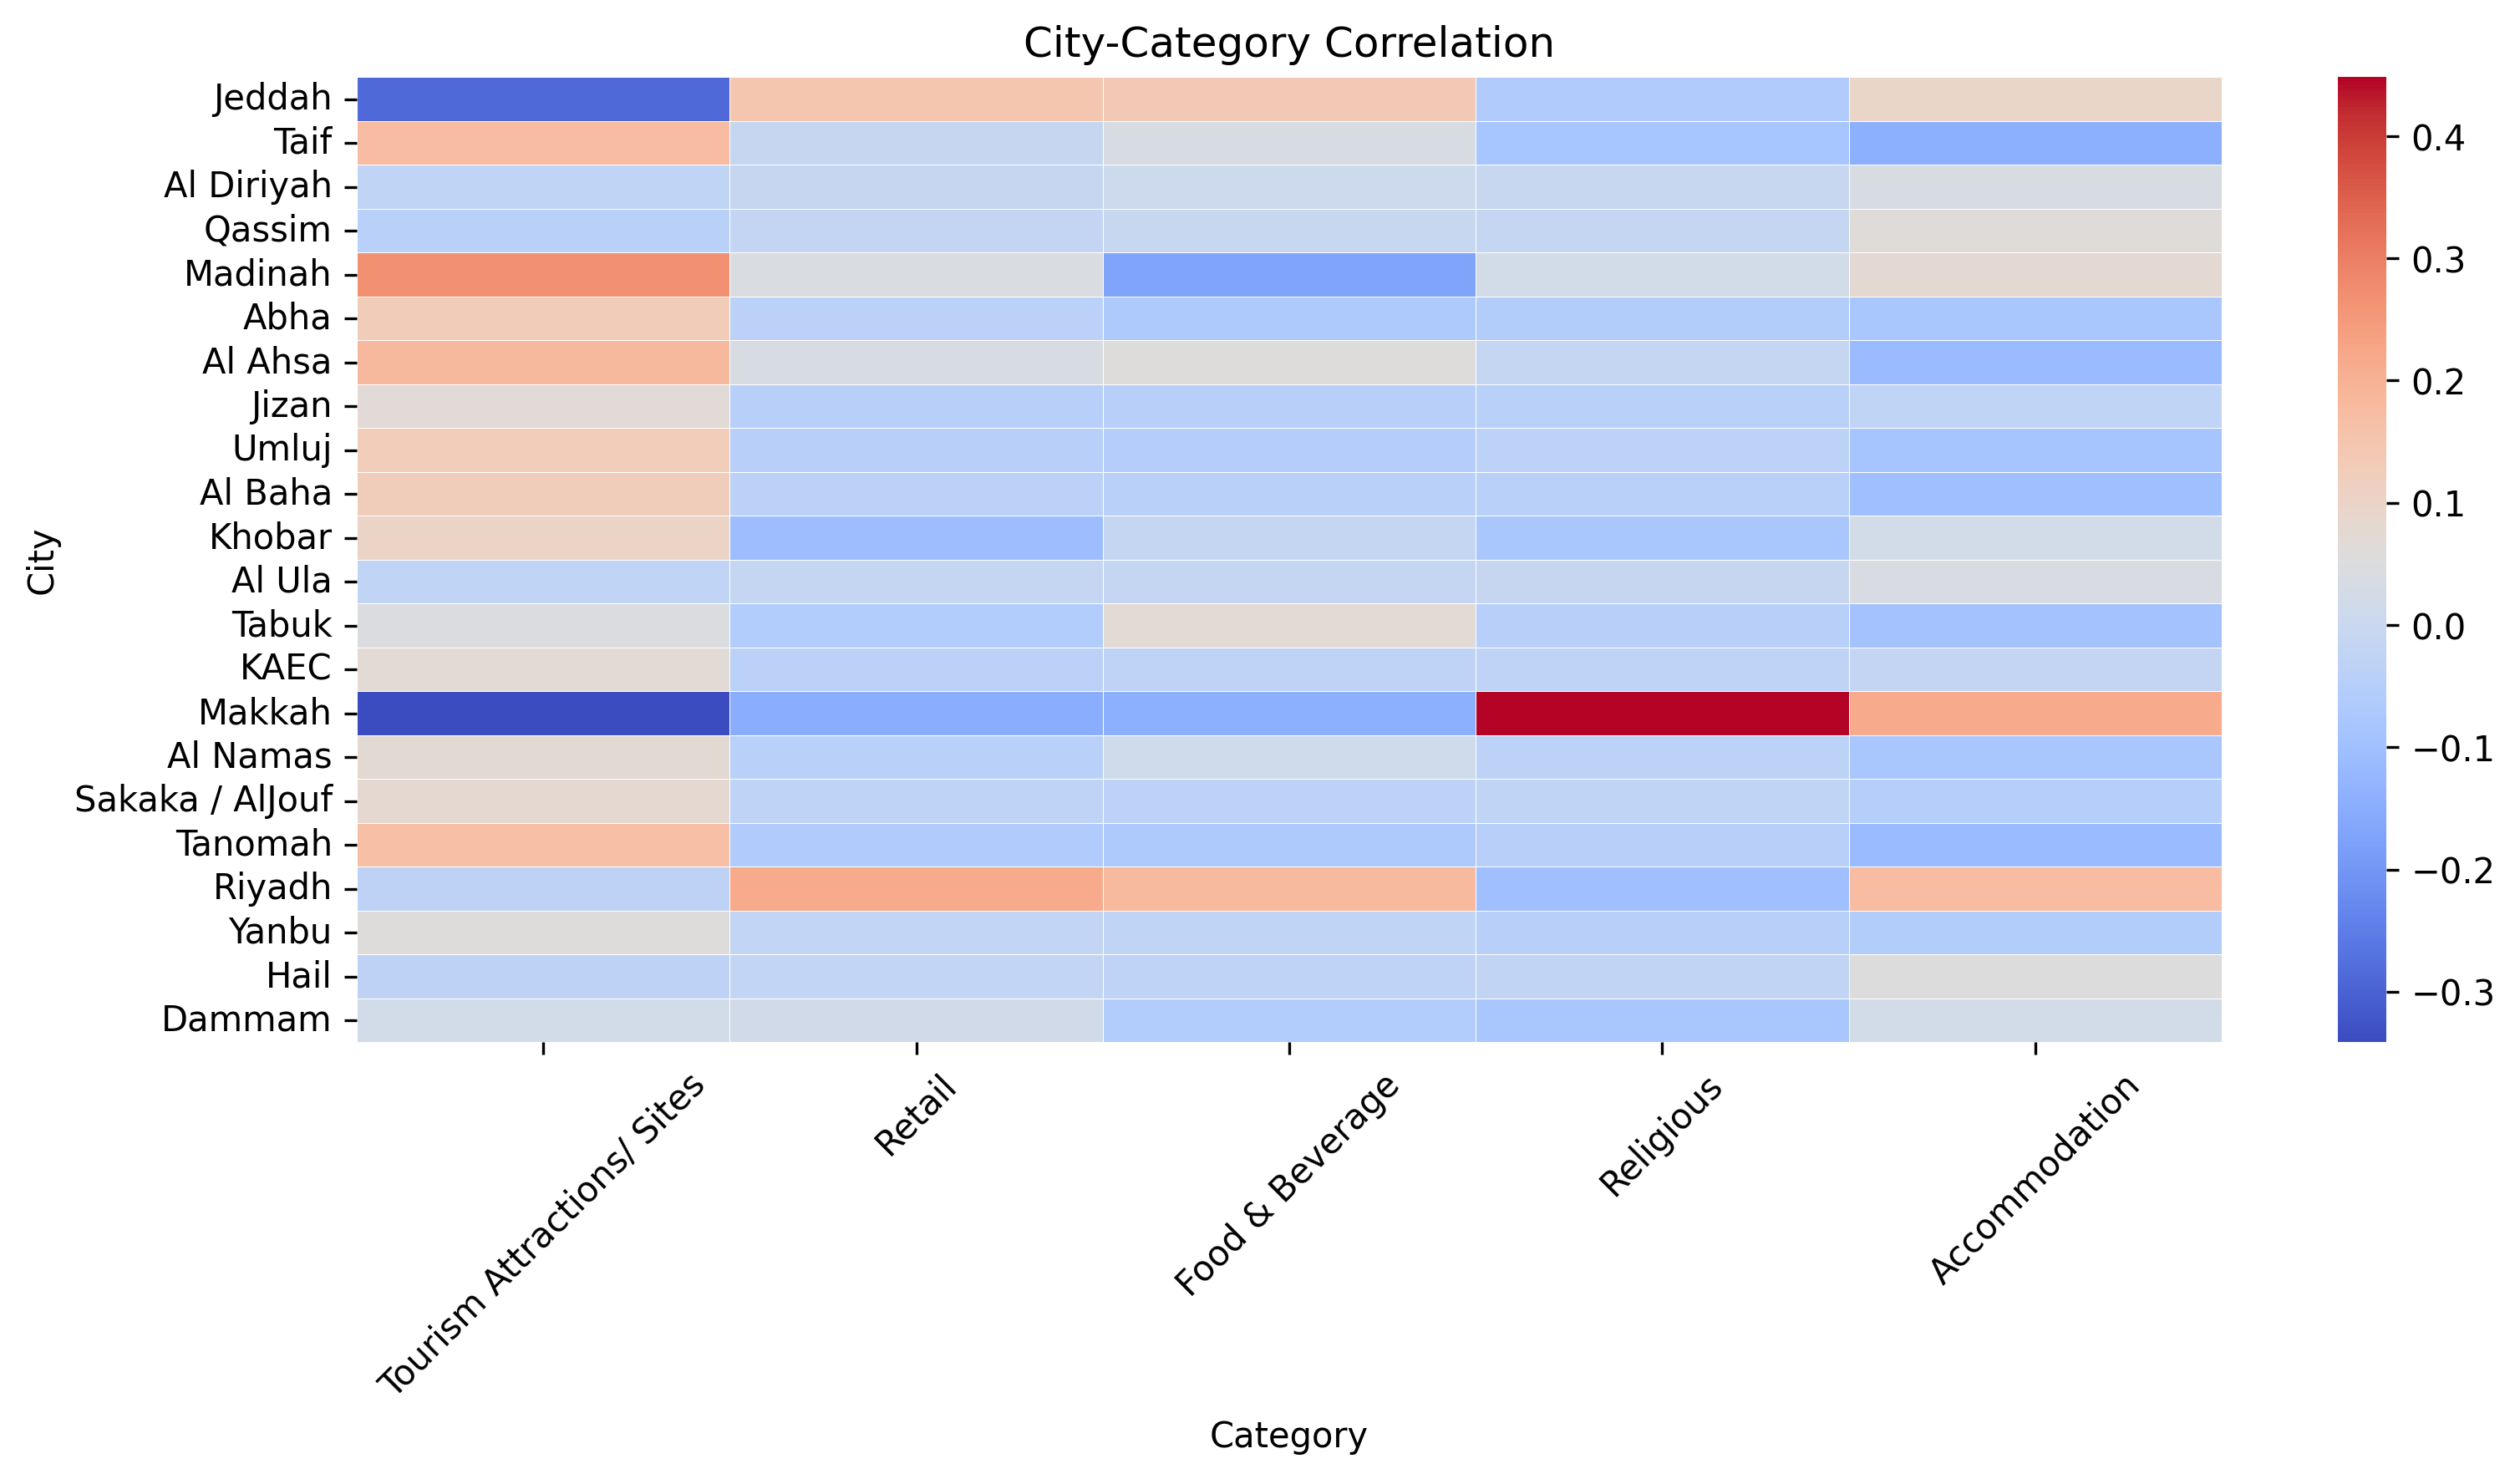

In [31]:
corr = encoded_tags.corr()

# Select cities as index and categories as columns
corr = corr.loc[cities, categories]

_, ax = plt.subplots(1, 1, figsize=(12, 5), dpi=300)

sns.heatmap(corr, ax=ax, linewidth=.2, cmap='coolwarm')
plt.xlabel('Category')
plt.ylabel('City')
plt.title('City-Category Correlation')
plt.xticks(rotation=45)

plt.savefig(
    f'{wm.root_dir_}/graphs/city_cat_correlation.png',
    bbox_inches='tight', transparent=True
    )
plt.show()

**Notes:**
- This is a mere approximation of the relation between categories and cities.
- We notice some relatively high correlation values that make sense. For example:
    - **Retail** category with:
        - `Riyadh` city (the capital)
        - `Jeddah` city (an important seaport)
    - **Accommodation** category with:
        - `Makkah` city (Hajj and Umrah)
        - `Riyadh` city
    - **Religious** category with:
        - `Makkah` city
    - **Tourism Attractions/ Sites** with:
        - `Madinah` city (Al-Masjid Al-Nabawy and other islamic sites).
        - `Makkah` city
        - `Jeddah` city
    - **Food & Beverage** with:
        - `Riyadh` city
        - `Jeddah` city

--------------------

# `05.` Conclusion <a name="5" id="5"></a>

## `i.` Summary <a name="5-1" id="5-1"></a>

[Back to Top](#top)

I have performed a comprehensive examination of **Google Reviews** dataset, focusing on extracting and interpreting _valuable insights_. To sum up, the steps I decided to follow for this analysis can be summarized below:
1. Introduction
    - Problem Formulation
    - Dataset Description
2. Workspace Preparation
    - Installing Dependancies
    - Importing Libraries
    - Configuring Settings
3. Data Preprocessing
    - Data Loading
    - Exploration
    - Transformations
        - Tags Extraction
        - Tags Encoding
        - Non-English Text Translation
        - Text Cleaning
        - Handlign Emojis
        - Ratings Extraction
        - Date Conversion
4. NLP Analysis
    - Sentiment Classification
    - Theme Analysis
5. Insights Extraction
    - Visualization
    - Graph Plotting

Let's walk through the main keypoints related to the data preprocessing approach I followed:
- Handling `tags` column was a challenge since each record could have a list of tags.
    - Cleaning, extracting, and mapping the tags themselves was straight forward.
    - However, deciding on which representation to use for the extracted tags (especially that each tag is a pair of _category_ and _city_).
    - I have then opted to have them in two different formats:
        - Expanding the list of (category, city) pairs into columns (which can be found in the `tags` DataFrame)
        - Encoding the combined unique `category` and `city` values in a _One-Hot Encoding_ like manner (stored in `encoded_tags` DataFrame)
    - This way I could use either of the representations as needed.
- Translating Non-English texts to English, as a way of standardizing NLP analysis, was a decision I made reluctantly. The main reasons included:
    - Since I cannot train models from scratch, it's ***easier*** to find algorithms, pre-trained models, and sentiment deriving techniques for English text than Arabic.
    - Arabic text, especially dialectal, have a lot of challenges that could be alleviated through translation.
    - The `language` is not totally accurate and hence cannot be relied upon.
- Text _cleaning and normalization_ play a **critical role** in the success of any NLP use case. And hence I have naturally collected together a pipeline for the basic and essential text cleaning steps.
    - These include:
        - Remove Punctuations.
        - Remove duplicate emojis.
        - Replace emojis with their meaning.
        - Remove extra whitespaces.
        - Remove stop-words.
    - However, after trying some of the sentiment analysis libraries (e.g., lexicon and rule-based), they were not to my satisfaction.
    - Thus, I decided to ultimately go with `transformers` and since they are designed to handle natural text, there was no meaning in using the `cleaned_text`.
    - That said, I strongly believe that, given more time, this `cleaned_text` could be used to extract meaningful insights (e.g., common words using embeddings, etc.).

As for **NLP text analysis**, it was handled in _two_ main tasks:
- Sentiment classification (i.e., classifying text into `Positive`, `Neutral`, or `Negative` class).
    - The **lack** of ground truth labels meant the **inability** to train models from scratch, and hence blocked _several routes_ that would have been a choice.
    - The remaining options were **limited** to either use algorithms that rely on _patterns, lexicons, and rule-based_ analysis; or resort to the vast ocean of _pre-trained transformers_.
    - Being unsatisfied with _lexicon and rule-based_ analysis, I started exploring _pre-trained models_, trying to pick the **most suitable** ones for the use case at hand.
    - The requirement of sentiment analysis lies under the **text classification** umbrella. However, after visually inspecting the results of a few pre-trained classifiers, I tried utilizing _zero-shot classification_ for SA.
    - The results are appealing to me. But **without target labels**, there are no numerical metrics that can be used to support them.
    - I have thought of manually labelling a random subset of samples for evaluation purposes using `doccano` or even manually; but that is not feasible in the tight timeframe available.
- Theme/ topic classification was an idea that seemed impractical.
    - That is due to the fact that I have first to find a set of themes to be candidate classes.
    - But then, how can I train a model without first labelling the data.
    - Additionally, unsupervised algorithms such as LDA or TopicBERT, require the text samples to be _longer, coherent, and less noisy_ to be able to extract meaningful topics.
    - Thus, again, I opted to use _zero-shot classification_ for theme analysis and even took advantage of multi-label capabilities of this approach.
    - Combining results from both **multi-class** and **multi-label** classification was done after careful analysis of the resulting predictions.
    - Once again, the **theme candidate classes** could have been phrased or selected in a _better_ way, resulting in better insights; but this could be considered in next steps.

Extracting meaningful insights is one of the **key objectives** of this analysis. That said, I have tried to incorporate as many components of the data as possible in the visual analysis.
- I was very interested in the _temporal_ component of the dataset.
    - However, the spread of the data records along the timeline was chaotic.
    - Even though the dates range between Feb $7^{th}$, $2021$ and Oct $3^{rd}$, $2023$, the actual bulk of reviews resides in the $3$-month period between Feb and Apr $2021$.
    - Thus, I was discouraged to further pursue this endeavor and decided to focus on other components.

- Next, I looked into _sentiment_ and _ratings_ distributions and relationship with each other.
- I have also investigated the potential relations among _categories_, _cities_, and _themes_.
- I tried my best to elaborate on potential insights and important observations after each graph.

-----------------------

## `ii.` Recommendations <a name="5-2" id="5-2"></a>

[Back to Top](#top)

Based on the limited-time analysis conducted, I can propose the following recommendations to improve businesses:
- Give due care to `cleanliness` since it's a _critical factor_ in customer satisfaction.
- Strategically _adjust_ `pricing` policies and provide **tiers** to alleviate the impact of economic inflation and attract more customers.
- Extract **personalized** insights per business (i.e., from the _textual content_ of reviews related to the business). This way the insights could be more useful to identify **weaknesses** to _mitigate_ and **strengths** to _boost_.
- Focus on improving **aspects** related to the most important themes mentioned in the reviews (namely, `Location`, `Experience`, and `Service`). This might be obvious, but sometimes underrated by business owners.
    - It might not be easy to change the `Location` altogether. However, it's possible to renovate, unleash the creativity, and transform the business to draw more attention.
    - Customer `Experience` and `Service` level are without a doubt crucial to maintaining their loyalty and satisfaction.
- Build a **detection model**, _if applicable_, that could for example identify potential unsatisfied customers in order to prioritize handling them.

Recommended **next steps** to _improve_ this analysis would include:
- Enhance the dataset (e.g., by adding new attributes, collecting more data for better aggregate insights, etc.).
- Conducting extra thorough investigation trying to squeeze insights out of `cleaned_text`.
- Focus more on unused columns such as `title`.
- Enhance the theme analysis (e.g., improve candidate classes, use different models, etc.).

-------------------------

With Love 🩵
$$ Abdelrahman \space A. \space Eid$$